# ⚡🤖💻 Deep Learning Pipeline: IIoT Intrusion  Detection 💻🤖⚡

### Objective: This notebook implements a binary and multiclass classification approach to detect security anomalies in an Industrial Internet of Things (IIoT) network using Deep Learning techniques.

## Network Traffic Data Analysis: Benign vs Attacks

### General Dataset Overview

This dataset, called *CICIOT 2025*, comes from a collection conducted on IoT devices connected to a local network.  
It contains both **benign records** (normal traffic) and **simulated network attacks**, including **DDoS (Distributed Denial of Service)** attacks, specifically **SYN Flood** attacks.


The main objective of this dataset is to support **network traffic analysis** and **automatic detection of abnormal behaviors**.  
It can be used to:
- **Train and evaluate** Machine Learning models for intrusion detection systems (IDS/IPS).
- **Analyze the differences** between normal and malicious traffic.
- **Build intelligent systems** capable of identifying attacks in real time within IoT environments.

---

### Dataset Structure

The dataset is organized into several categories of features:

#### 1. Device Identification
- Device name and MAC address (e.g., router, IP camera, IoT gateway).

#### 2. Labels
- Indicate whether a sample is benign or malicious, with different levels of granularity  
  (`label_full`, `label1`, `label2`, etc.).

#### 3. Temporal Information
- Start and end timestamps for each collected sample.

#### 4. Log Features
- Information related to system or application logs generated during the sample.

#### 5. Network Features
- A set of metrics describing network traffic:
  - Fragmentation
  - Packet size
  - Protocols used
  - Ports
  - TCP/IP flags
  - Time To Live (TTL), etc.

---

### Key Differences Between Scenarios

#### Benign Traffic
- Non-null and consistent feature values.
- Presence of diverse IP/MAC addresses, ports, and protocols.
- Stable and regular network activity.

#### Attack Traffic (e.g., DDoS SYN Flood)
- Numerous null or zero values, reflecting saturated or abnormal traffic.
- Abnormally high TCP flags (`SYN`, `ACK`), typical of flooding attacks.
- Reduced diversity of IP addresses and ports used.


## 1. Imports and Global Configuration

We import standard libraries (`pandas`, `numpy`), visualization tools (`matplotlib`, `seaborn`), and the `TensorFlow` framework for Deep Learning.

### Hyperparameter Configuration

Here, we define the global constants used in the model:
- **SEQUENCE_LENGTH:** 10 (length of the temporal windows).
- **EPOCHS:** 25.
- **BATCH_SIZE:** 256.


In [11]:
 

# ===============================
# IMPORTS ET CONFIGURATION
# ===============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, auc)
from sklearn.utils.class_weight import compute_class_weight

 

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.4f' % x)



print("=" * 80)
print("PIPELINE ML UNIFIÉ - DÉTECTION D'ATTAQUES IIoT")
print("Classification Binaire et Multiclass")
print("=" * 80)

# ===============================
# PARAMÈTRES GLOBAUX
# ===============================
SEQUENCE_LENGTH = 10
EPOCHS = 25
BATCH_SIZE = 256

TEST_SIZE = 0.3
VAL_SIZE = 0.5
LEARNING_RATE = 0.001
RANDOM_STATE = 42

print("\nConfiguration:")
print(f"  Sequence Length: {SEQUENCE_LENGTH}")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Learning Rate: {LEARNING_RATE}")


PIPELINE ML UNIFIÉ - DÉTECTION D'ATTAQUES IIoT
Classification Binaire et Multiclass

Configuration:
  Sequence Length: 10
  Epochs: 25
  Batch Size: 256
  Learning Rate: 0.001


## 2. Data Loading

The data is loaded from CSV files segmented by time windows (from 1 to 10 seconds) for both benign and malicious classes.

> **Note:** A binary label `dataset_type` ("benign" vs. "attack") is added before the final merging of the datasets.


In [3]:
import os
import pandas as pd

# ===============================
# 0. CHEMIN DU DOSSIER CSV
# ===============================
DATA_DIR = "/kaggle/input/datazip1/mydata"  # dossier contenant déjà les CSV

# ===============================
# 1. CHARGEMENT DES DONNEES
# ===============================
print("\n" + "=" * 80)
print("ETAPE 1 : CHARGEMENT DES DONNEES")
print("=" * 80)

seconds = list(range(1, 11))

# ===============================
# BENIGN CSV
# ===============================
df_benign_list = []

for sec in seconds:
    fichier = os.path.join(DATA_DIR, f"benign_samples_{sec}sec.csv")
    if os.path.exists(fichier):
        df = pd.read_csv(fichier)
        df_benign_list.append(df)
        print(f"{os.path.basename(fichier)} chargé : {df.shape[0]} lignes, {df.shape[1]} colonnes")
    else:
        print(f"{os.path.basename(fichier)} introuvable")

if df_benign_list:
    df_benign = pd.concat(df_benign_list, ignore_index=True)
else:
    raise FileNotFoundError("Aucun fichier BENIGN n'a été chargé")

print("\nDataset BENIGN")
print(f"Total : {df_benign.shape[0]} lignes, {df_benign.shape[1]} colonnes")

# ===============================
# ATTACK CSV
# ===============================
df_attack_list = []

for sec in seconds:
    fichier = os.path.join(DATA_DIR, f"attack_samples_{sec}sec.csv")
    if os.path.exists(fichier):
        df = pd.read_csv(fichier)
        df_attack_list.append(df)
        print(f"{os.path.basename(fichier)} chargé : {df.shape[0]} lignes, {df.shape[1]} colonnes")
    else:
        print(f"{os.path.basename(fichier)} introuvable")

if df_attack_list:
    df_attack = pd.concat(df_attack_list, ignore_index=True)
else:
    raise FileNotFoundError("Aucun fichier ATTACK n'a été chargé")

print("\nDataset ATTACK")
print(f"Total : {df_attack.shape[0]} lignes, {df_attack.shape[1]} colonnes")

# ===============================
# VERIFICATIONS
# ===============================
print("\nVérification des colonnes")
print("Colonnes identiques :", df_benign.columns.equals(df_attack.columns))

# ===============================
# AJOUT DU LABEL BINAIRE
# ===============================
df_benign["dataset_type"] = "benign"
df_attack["dataset_type"] = "attack"

# ===============================
# FUSION FINALE
# ===============================
df_all = pd.concat([df_benign, df_attack], ignore_index=True)

print("\nDataset combiné")
print("Shape :", df_all.shape)

print("\nDistribution des classes (label2)")
print(df_all["label2"].value_counts(dropna=False))

print("\nDistribution binaire (dataset_type)")
print(df_all["dataset_type"].value_counts())


ETAPE 1 : CHARGEMENT DES DONNEES
benign_samples_1sec.csv chargé : 136800 lignes, 94 colonnes
benign_samples_2sec.csv chargé : 68400 lignes, 94 colonnes
benign_samples_3sec.csv chargé : 45600 lignes, 94 colonnes
benign_samples_4sec.csv chargé : 34200 lignes, 94 colonnes
benign_samples_5sec.csv chargé : 27360 lignes, 94 colonnes
benign_samples_6sec.csv chargé : 22800 lignes, 94 colonnes
benign_samples_7sec.csv chargé : 19532 lignes, 94 colonnes
benign_samples_8sec.csv chargé : 17100 lignes, 94 colonnes
benign_samples_9sec.csv chargé : 15200 lignes, 94 colonnes
benign_samples_10sec.csv chargé : 13680 lignes, 94 colonnes

Dataset BENIGN
Total : 400672 lignes, 94 colonnes
attack_samples_1sec.csv chargé : 90391 lignes, 94 colonnes
attack_samples_2sec.csv chargé : 44744 lignes, 94 colonnes
attack_samples_3sec.csv chargé : 29627 lignes, 94 colonnes
attack_samples_4sec.csv chargé : 22165 lignes, 94 colonnes
attack_samples_5sec.csv chargé : 17695 lignes, 94 colonnes
attack_samples_6sec.csv char

## 3. Exploratory Data Analysis (EDA)

This section focuses on analyzing the structure of the combined dataset (approximately 685,000 rows).

### 3.1. Feature Cleaning and Selection
- **Excluded columns:** Hardware identifiers (`device_mac`), timestamps, and detailed labels.
- **Numerical features:** 71 variables identified for model training.

### 3.2. Class Distribution
Visualization of the class imbalance between normal (benign) traffic and the different types of attacks (`label2`).



ÉTAPE 2 : EXPLORATORY DATA ANALYSIS

Nombre de features numériques: 71
Premières features: ['log_data-ranges_avg', 'log_data-ranges_max', 'log_data-ranges_min', 'log_data-ranges_std_deviation', 'log_data-types_count', 'log_interval-messages', 'log_messages_count', 'network_fragmentation-score', 'network_fragmented-packets', 'network_header-length_avg']

Statistiques descriptives:
       log_data-ranges_avg  log_data-ranges_max  log_data-ranges_min  \
count          685671.0000          685671.0000          685671.0000   
mean               59.8387              61.4138              57.3982   
std               215.6094             218.0695             210.0544   
min                 0.0000               0.0000              -0.9400   
25%                 0.0000               0.0000               0.0000   
50%                 0.0000               0.0000               0.0000   
75%                 0.0000               0.0000               0.0000   
max              2000.0000            20

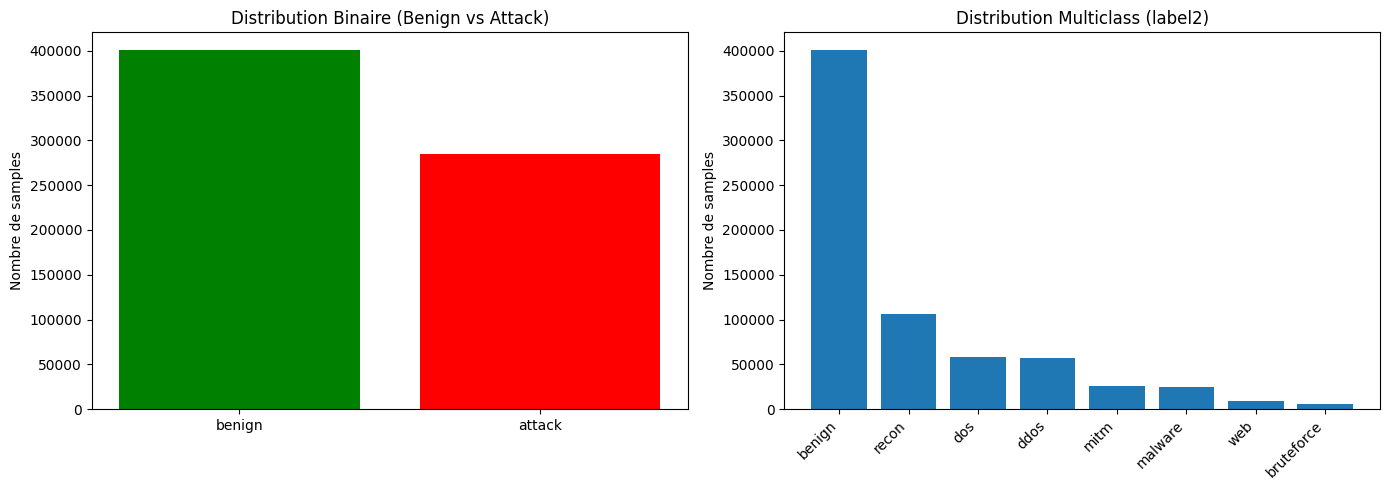

In [4]:
# ===============================
# ÉTAPE 2 : EDA (EXPLORATORY DATA ANALYSIS)
# ===============================
print("\n" + "=" * 80)
print("ÉTAPE 2 : EXPLORATORY DATA ANALYSIS")
print("=" * 80)

df = df_all.copy()

# Colonnes à exclure
exclude_cols = [
    'device_name', 'device_mac', 'label_full', 'label1', 'label2', 
    'label3', 'label4', 'timestamp', 'timestamp_start', 'timestamp_end',
    'dataset_type'
]

# Colonnes de type liste
list_cols = [
    'log_data-types', 'network_ips_all', 'network_ips_dst', 'network_ips_src',
    'network_macs_all', 'network_macs_dst', 'network_macs_src',
    'network_ports_all', 'network_ports_dst', 'network_ports_src',
    'network_protocols_all', 'network_protocols_dst', 'network_protocols_src'
]

for col in list_cols:
    if col in df.columns:
        df = df.drop(columns=[col])

# Sélection des features numériques
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

print(f"\nNombre de features numériques: {len(numeric_cols)}")
print(f"Premières features: {numeric_cols[:10]}")

# Statistiques descriptives
print("\nStatistiques descriptives:")
print(df[numeric_cols].describe())

# Vérification des valeurs manquantes
print("\nValeurs manquantes:")
missing_pct = (df[numeric_cols].isnull().sum() / len(df)) * 100
print(missing_pct[missing_pct > 0])
if missing_pct.sum() == 0:
    print("Aucune valeur manquante")

# Distribution des classes
print("\nDistribution des classes:")
print(f"  Benign: {(df_all['dataset_type'] == 'benign').sum()}")
print(f"  Attack: {(df_all['dataset_type'] == 'attack').sum()}")

# Visualisation de la distribution des classes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Binaire
dataset_counts = df_all['dataset_type'].value_counts()
axes[0].bar(dataset_counts.index, dataset_counts.values, color=['green', 'red'])
axes[0].set_title('Distribution Binaire (Benign vs Attack)')
axes[0].set_ylabel('Nombre de samples')

# Multiclass
label2_counts = df_all['label2'].value_counts()
axes[1].bar(range(len(label2_counts)), label2_counts.values)
axes[1].set_xticks(range(len(label2_counts)))
axes[1].set_xticklabels(label2_counts.index, rotation=45, ha='right')
axes[1].set_title('Distribution Multiclass (label2)')
axes[1].set_ylabel('Nombre de samples')

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=100, bbox_inches='tight')
plt.show()







## 4. Preprocessing and Feature Engineering

Before training, the data undergoes the following transformations:

1. **Imputation:**  
   Replacement of infinite or missing values with `0.0`.

2. **Normalization:**  
   Use of `StandardScaler` to achieve a mean of 0 and a standard deviation of 1.

3. **Sequencing:**  
   Conversion of the data into 3D tensors  
   `(samples, time_steps, features)` for recurrent layers (GRU/LSTM).

4. **Correlation Analysis and Feature Reduction:**  
   - **Before feature removal:** A correlation matrix is computed to identify highly correlated features.
   - **After feature removal:** Redundant features with correlation above a predefined threshold are removed to reduce dimensionality, mitigate multicollinearity, and improve model generalization.




ÉTAPE 3 : PREPROCESSING ET FEATURE ENGINEERING

Shape des features: (685671, 71)
Données normalisées - Mean: 0.000000, Std: 1.000000
Séquences créées: (685671, 10, 71)


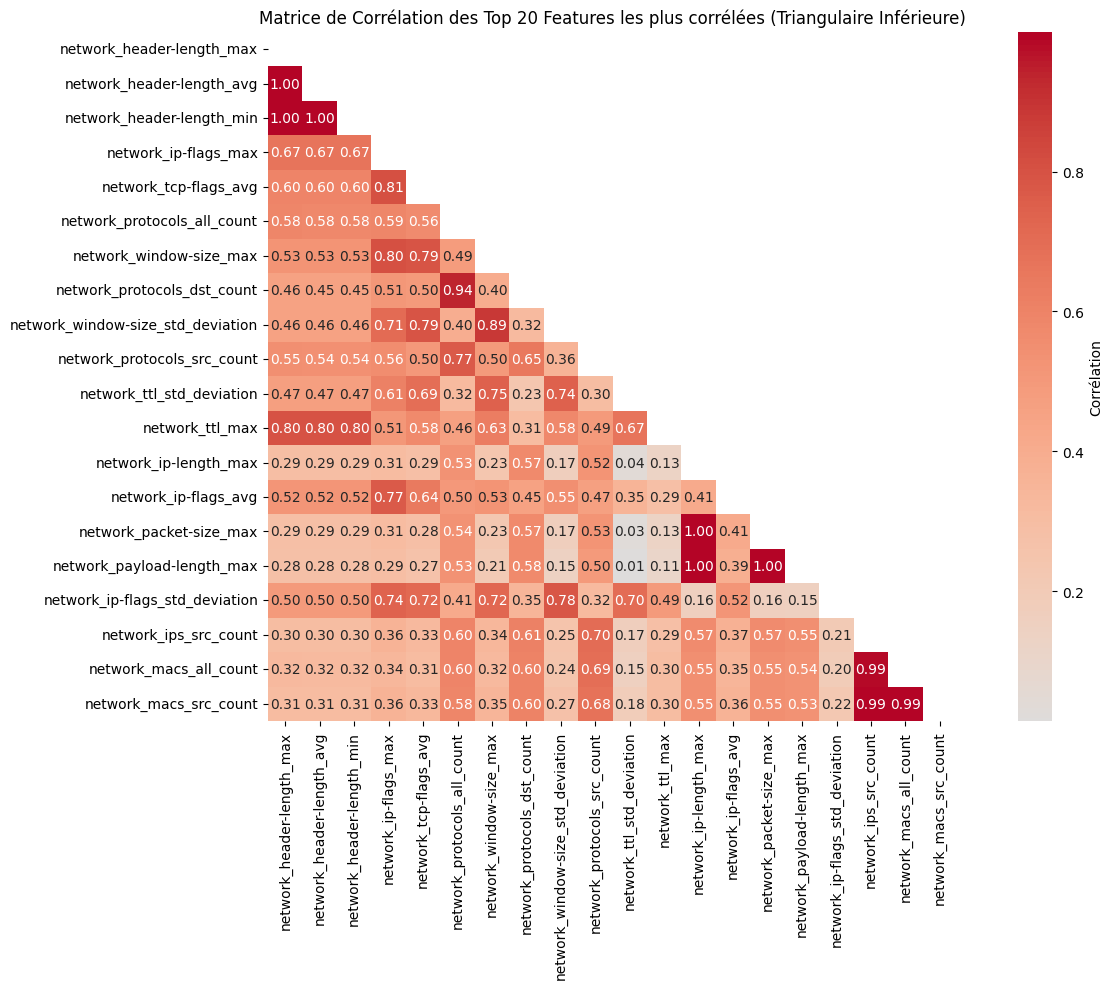

In [5]:
# ===============================
# ÉTAPE 3 : PREPROCESSING ET FEATURE ENGINEERING
# ===============================
print("\n" + "=" * 80)
print("ÉTAPE 3 : PREPROCESSING ET FEATURE ENGINEERING")
print("=" * 80)

X = df[numeric_cols].values
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

print(f"\nShape des features: {X.shape}")

# Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"Données normalisées - Mean: {X_scaled.mean():.6f}, Std: {X_scaled.std():.6f}")

# Création des séquences
n_samples, n_features = X_scaled.shape
X_sequences = np.tile(X_scaled[:, np.newaxis, :], (1, SEQUENCE_LENGTH, 1))
noise = np.random.normal(0, 0.01, X_sequences.shape)
X_sequences = X_sequences + noise
print(f"Séquences créées: {X_sequences.shape}")

# Matrice de corrélation
 
df_features = pd.DataFrame(X_scaled, columns=numeric_cols)

# Calcul de la matrice de corrélation complète
corr_matrix_full = df_features.corr().abs()  # prendre la valeur absolue

# Somme des corrélations pour chaque feature (exclure la diagonale)
np.fill_diagonal(corr_matrix_full.values, 0)
top_20_features = corr_matrix_full.sum().sort_values(ascending=False).head(20).index

# Matrice de corrélation restreinte aux top 20
corr_matrix_top20 = df_features[top_20_features].corr()

# Masque pour la partie supérieure
mask = np.triu(np.ones_like(corr_matrix_top20, dtype=bool))

plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix_top20,
    mask=mask,
    cmap='coolwarm',
    center=0,
    square=True,
    annot=True,
    fmt=".2f",
    cbar_kws={'label': 'Corrélation'},
    xticklabels=True,
    yticklabels=True
)

plt.title('Matrice de Corrélation des Top 20 Features les plus corrélées (Triangulaire Inférieure)')
plt.tight_layout()
plt.savefig('correlation_matrix_top20_corr.png', dpi=100, bbox_inches='tight')
plt.show()

In [6]:
# ===============================
# ÉTAPE 4 : SUPPRESSION DES FEATURES FORTEMENT CORRÉLÉES
# ===============================
print("\n" + "=" * 80)
print("ÉTAPE 4 : FEATURE SELECTION PAR CORRÉLATION")
print("=" * 80)

# Création DataFrame pour corrélation
df_num = pd.DataFrame(X_scaled, columns=numeric_cols)

# Matrice de corrélation absolue
corr_matrix = df_num.corr().abs()

# Triangle supérieur de la matrice (pour éviter les doublons)
upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# Seuil de corrélation
CORR_THRESHOLD = 0.9

# Features à supprimer
to_drop = [
    column for column in upper_triangle.columns
    if any(upper_triangle[column] > CORR_THRESHOLD)
]

print(f"Seuil de corrélation utilisé : {CORR_THRESHOLD}")
print(f"Nombre de features supprimées : {len(to_drop)}")

# Suppression des features corrélées
df_num_reduced = df_num.drop(columns=to_drop)

# Mise à jour des variables
numeric_cols_reduced = df_num_reduced.columns.tolist()
X_reduced = df_num_reduced.values

print(f"Nombre de features avant : {len(numeric_cols)}")
print(f"Nombre de features après  : {len(numeric_cols_reduced)}")

# Remplacement pour la suite du pipeline
numeric_cols = numeric_cols_reduced
X_scaled = X_reduced

print("Feature selection par corrélation terminée avec succès ✅")



ÉTAPE 4 : FEATURE SELECTION PAR CORRÉLATION
Seuil de corrélation utilisé : 0.9
Nombre de features supprimées : 23
Nombre de features avant : 71
Nombre de features après  : 48
Feature selection par corrélation terminée avec succès ✅


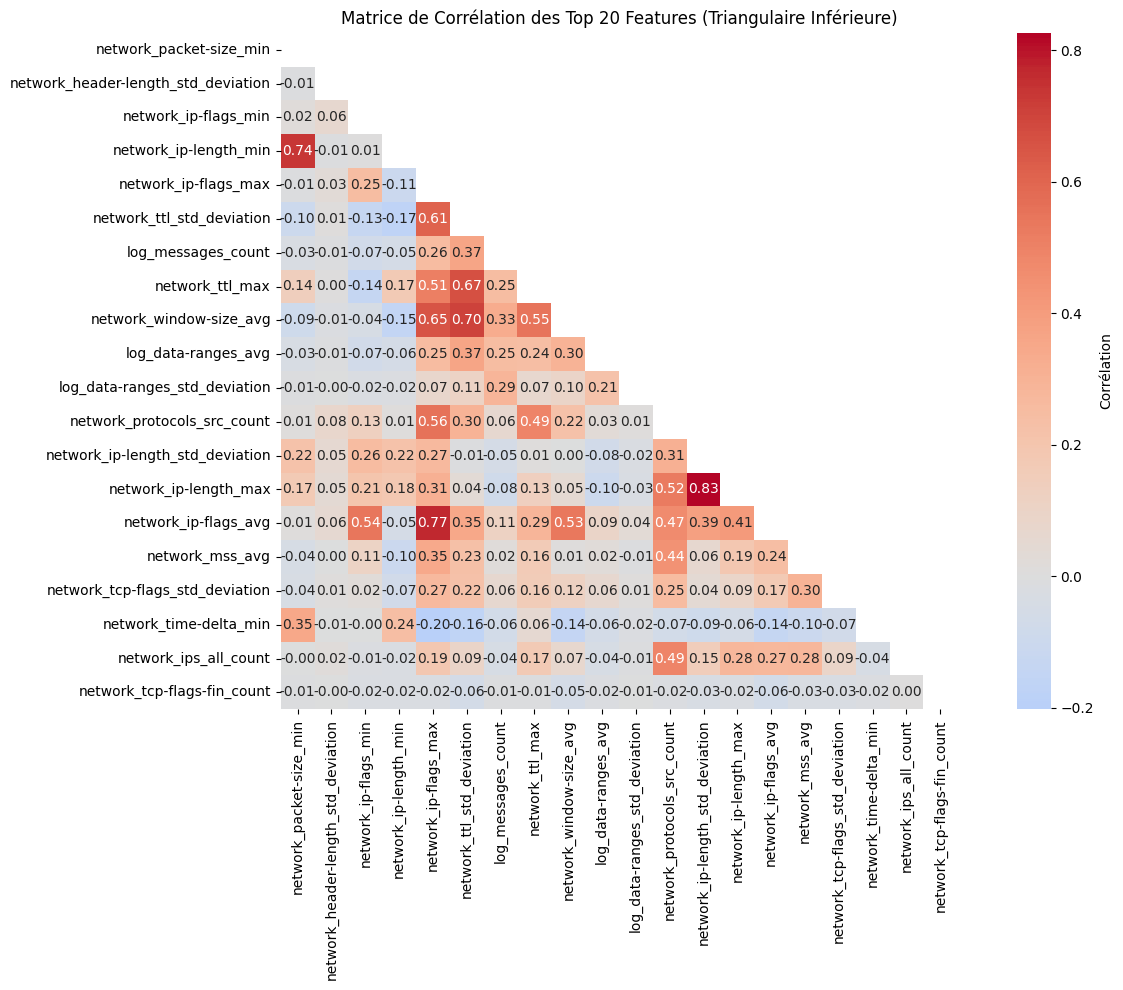

In [7]:
# DataFrame des features
df_features = pd.DataFrame(X_scaled, columns=numeric_cols)

# Sélection des top 20 features par variance (ou selon un critère pertinent)
top_20_features = df_features.var().sort_values(ascending=False).head(20).index

# Matrice de corrélation restreinte aux top 20
corr_matrix_top20 = df_features[top_20_features].corr()

# Masque pour la partie supérieure
mask = np.triu(np.ones_like(corr_matrix_top20, dtype=bool))

plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix_top20,
    mask=mask,
    cmap='coolwarm',
    center=0,
    square=True,
    annot=True,
    fmt=".2f",
    cbar_kws={'label': 'Corrélation'},
    xticklabels=True,
    yticklabels=True
)

plt.title('Matrice de Corrélation des Top 20 Features (Triangulaire Inférieure)')
plt.tight_layout()
plt.savefig('correlation_matrix_top20_lower.png', dpi=100, bbox_inches='tight')
plt.show()

## Step 4: Preparation for Binary Classification

This step focuses on preparing the dataset for **binary classification**, where the objective is to distinguish between **benign** and **attack** network traffic.

### 4.1 Binary Label Encoding
The target variable `dataset_type` is encoded into binary labels using a `LabelEncoder`, where:
- `0` represents **benign** traffic
- `1` represents **attack** traffic

The class names and their distribution are displayed to verify label correctness and detect any potential class imbalance.

### 4.2 Train–Validation–Test Split
The sequential feature tensors are split into three subsets:
- **Training set**
- **Validation set**
- **Test set**

The split is performed using **stratified sampling** to preserve the original class distribution across all subsets.  
Fixed random seeds are used to ensure **reproducibility**.

### 4.3 Dataset Size Summary
The number of samples in each subset (train, validation, and test) is printed to confirm the correctness of the split.


In [9]:
# ===============================
# ÉTAPE 4 : PRÉPARATION POUR CLASSIFICATION BINAIRE
# ===============================
print("\n" + "=" * 80)
print("ÉTAPE 4A : CLASSIFICATION BINAIRE (Benign vs Attack)")
print("=" * 80)

# Encodage binaire
label_encoder_binary = LabelEncoder()
y_binary = label_encoder_binary.fit_transform(df_all['dataset_type'])
print(f"\nClasses binaires: {label_encoder_binary.classes_}")
print(f"Distribution: {np.bincount(y_binary)}")

# Split
X_train_bin, X_temp_bin, y_train_bin, y_temp_bin = train_test_split(
    X_sequences, y_binary, test_size=TEST_SIZE, stratify=y_binary, random_state=RANDOM_STATE
)
X_val_bin, X_test_bin, y_val_bin, y_test_bin = train_test_split(
    X_temp_bin, y_temp_bin, test_size=VAL_SIZE, stratify=y_temp_bin, random_state=RANDOM_STATE
)

print(f"\nSplit Train/Val/Test (Binaire):")
print(f"  Train: {X_train_bin.shape[0]} samples")
print(f"  Val:   {X_val_bin.shape[0]} samples")
print(f"  Test:  {X_test_bin.shape[0]} samples")



ÉTAPE 4A : CLASSIFICATION BINAIRE (Benign vs Attack)

Classes binaires: ['attack' 'benign']
Distribution: [284999 400672]

Split Train/Val/Test (Binaire):
  Train: 479969 samples
  Val:   102851 samples
  Test:  102851 samples


## Step 5: Preparation for Multiclass Classification

This step prepares the dataset for **multiclass classification**, where the goal is to identify the **specific type of network traffic or attack** using the `label2` target variable.

### 5.1 Multiclass Label Encoding
The categorical variable `label2` is encoded into numerical labels using a `LabelEncoder`.  
The total number of classes and their corresponding labels are displayed to verify correct encoding and class distribution.

### 5.2 Train–Validation–Test Split
The sequential input data is divided into:
- **Training set**
- **Validation set**
- **Test set**

A **stratified split** is applied to ensure that each class is proportionally represented across all subsets.  
A fixed random seed is used to guarantee **reproducibility** of the experiment.

### 5.3 Dataset Size Summary
The number of samples in each subset (training, validation, and test) is printed to validate the correctness of the data splitting process.


In [10]:
# ===============================
# ÉTAPE 5 : PRÉPARATION POUR CLASSIFICATION MULTICLASS
# ===============================
print("\n" + "=" * 80)
print("ÉTAPE 4B : CLASSIFICATION MULTICLASS (label2)")
print("=" * 80)

# Encodage multiclass
label_encoder_multi = LabelEncoder()
y_multi = label_encoder_multi.fit_transform(df_all['label2'])
num_classes = len(label_encoder_multi.classes_)
print(f"\nClasses multiclass ({num_classes}): {label_encoder_multi.classes_}")
print(f"Distribution: {np.bincount(y_multi)}")

# Split
X_train_mul, X_temp_mul, y_train_mul, y_temp_mul = train_test_split(
    X_sequences, y_multi, test_size=TEST_SIZE, stratify=y_multi, random_state=RANDOM_STATE
)
X_val_mul, X_test_mul, y_val_mul, y_test_mul = train_test_split(
    X_temp_mul, y_temp_mul, test_size=VAL_SIZE, stratify=y_temp_mul, random_state=RANDOM_STATE
)

print(f"\nSplit Train/Val/Test (Multiclass):")
print(f"  Train: {X_train_mul.shape[0]} samples")
print(f"  Val:   {X_val_mul.shape[0]} samples")
print(f"  Test:  {X_test_mul.shape[0]} samples")



ÉTAPE 4B : CLASSIFICATION MULTICLASS (label2)

Classes multiclass (8): ['benign' 'bruteforce' 'ddos' 'dos' 'malware' 'mitm' 'recon' 'web']
Distribution: [400672   6016  56692  57736  24177  25490 105848   9040]

Split Train/Val/Test (Multiclass):
  Train: 479969 samples
  Val:   102851 samples
  Test:  102851 samples


# 1. Pure CNN Model

This section defines a **pure CNN architecture** for sequence-based network traffic classification. The model consists of multiple convolutional blocks followed by fully connected layers, designed to handle **temporal sequences** of network features.

### Architecture Details

1. **Input Layer**
   - Shape: `(SEQUENCE_LENGTH, n_features)` representing temporal sequences of network features.

2. **Convolutional Blocks**
   - **Block 1:** Conv1D → BatchNorm → MaxPooling → Dropout
   - **Block 2:** Conv1D → BatchNorm → MaxPooling → Dropout
   - **Block 3:** Conv1D → BatchNorm → GlobalAveragePooling

3. **Fully Connected Layers**
   - Dense 128 → ReLU → Dropout
   - Dense 64 → ReLU → Dropout

4. **Output Layer**
   - **Binary classification:** 1 neuron with `sigmoid` activation, loss = `binary_crossentropy`, metrics = `[accuracy, AUC]`.
   - **Multiclass classification:** `num_classes` neurons with `softmax` activation, loss = `sparse_categorical_crossentropy`, metrics = `[accuracy]`.

### Compilation
- Optimizer: `Adam` with learning rate `LEARNING_RATE`.
- Metrics and loss are set according to the classification type (binary or multiclass).

The function `build_cnn_model(num_classes, classification_type)` returns the compiled CNN model ready for training.


In [9]:
# ===============================
# 1. MODÈLE CNN PUR
# ===============================
def build_cnn_model(num_classes, classification_type='binary'):
    """Architecture CNN pure avec plusieurs couches convolutionnelles"""
    input_shape = (SEQUENCE_LENGTH, n_features)
    inputs = keras.Input(shape=input_shape)
    
    # Bloc CNN 1
    x = layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(0.3)(x)
    
    # Bloc CNN 2
    x = layers.Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(0.3)(x)
    
    # Bloc CNN 3
    x = layers.Conv1D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    
    # Classification
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    
    # Sortie
    if classification_type == 'binary':
        outputs = layers.Dense(1, activation='sigmoid')(x)
        loss_fn = 'binary_crossentropy'
        metrics_list = ['accuracy', keras.metrics.AUC(name='auc')]
    else:
        outputs = layers.Dense(num_classes, activation='softmax')(x)
        loss_fn = 'sparse_categorical_crossentropy'
        metrics_list = ['accuracy']
    
    model = keras.Model(inputs=inputs, outputs=outputs, name='CNN_Pure')
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss=loss_fn,
        metrics=metrics_list
    )
    
    return model


# 2. CNN + BiLSTM Model

This section defines a **hybrid CNN + BiLSTM architecture** for sequence-based network traffic classification.  
The model combines convolutional layers for feature extraction with Bidirectional LSTM layers for capturing **temporal dependencies** in the sequential data.

### Architecture Details

1. **Input Layer**
   - Shape: `(SEQUENCE_LENGTH, n_features)` representing temporal sequences of network features.

2. **Convolutional Block**
   - Conv1D → BatchNorm → MaxPooling (filters: 64)
   - Conv1D → BatchNorm → MaxPooling (filters: 128)
   - Dropout 0.3

3. **Bidirectional LSTM Block**
   - BiLSTM 64 (return sequences = True) → Dropout 0.3
   - BiLSTM 32 (return sequences = False) → Dropout 0.3

4. **Fully Connected Layers**
   - Dense 128 → ReLU → Dropout 0.4
   - Dense 64 → ReLU → Dropout 0.4

5. **Output Layer**
   - **Binary classification:** 1 neuron with `sigmoid` activation, loss = `binary_crossentropy`, metrics = `[accuracy, AUC]`.
   - **Multiclass classification:** `num_classes` neurons with `softmax` activation, loss = `sparse_categorical_crossentropy`, metrics = `[accuracy]`.

### Compilation
- Optimizer: `Adam` with learning rate `LEARNING_RATE`.
- Metrics and loss depend on the classification type (binary or multiclass).

The function `build_cnn_bilstm_model(num_classes, classification_type)` returns the compiled hybrid model ready for training.


In [10]:
# ===============================
# 2. MODÈLE CNN + BiLSTM
# ===============================
def build_cnn_bilstm_model(num_classes, classification_type='binary'):
    """Architecture CNN + BiLSTM"""
    input_shape = (SEQUENCE_LENGTH, n_features)
    inputs = keras.Input(shape=input_shape)
    
    # Bloc CNN
    x = layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(0.3)(x)
    
    # Bloc BiLSTM
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Bidirectional(layers.LSTM(32, return_sequences=False))(x)
    x = layers.Dropout(0.3)(x)
    
    # Classification
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    
    # Sortie
    if classification_type == 'binary':
        outputs = layers.Dense(1, activation='sigmoid')(x)
        loss_fn = 'binary_crossentropy'
        metrics_list = ['accuracy', keras.metrics.AUC(name='auc')]
    else:
        outputs = layers.Dense(num_classes, activation='softmax')(x)
        loss_fn = 'sparse_categorical_crossentropy'
        metrics_list = ['accuracy']
    
    model = keras.Model(inputs=inputs, outputs=outputs, name='CNN_BiLSTM')
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss=loss_fn,
        metrics=metrics_list
    )
    
    return model


# 3. Pure Transformer Model

This section defines a **pure Transformer architecture** for sequence-based network traffic classification.  
The model leverages **self-attention mechanisms** to capture long-range dependencies in temporal sequences.

### Architecture Details

1. **Input Layer**
   - Shape: `(SEQUENCE_LENGTH, n_features)` representing temporal sequences of network features.

2. **Initial Projection**
   - Dense layer projecting input features to 128 dimensions.

3. **Transformer Blocks**
   - **Block 1 & 2:**
     - Multi-Head Attention (4 heads, key dimension = 32, dropout = 0.2)
     - Residual connection + Layer Normalization
     - Feed-Forward Network (Dense 256 → ReLU → Dropout 0.2 → Dense 128)
     - Residual connection + Layer Normalization

4. **Fully Connected Layers**
   - GlobalAveragePooling1D → Dense 128 → ReLU → Dropout 0.4
   - Dense 64 → ReLU → Dropout 0.4

5. **Output Layer**
   - **Binary classification:** 1 neuron with `sigmoid` activation, loss = `binary_crossentropy`, metrics = `[accuracy, AUC]`.
   - **Multiclass classification:** `num_classes` neurons with `softmax` activation, loss = `sparse_categorical_crossentropy`, metrics = `[accuracy]`.

### Compilation
- Optimizer: `Adam` with learning rate `LEARNING_RATE`.
- Metrics and loss are selected according to the classification type (binary or multiclass).

The function `build_transformer_model(num_classes, classification_type)` returns the compiled Transformer model ready for training.


In [11]:
# ===============================
# 3. MODÈLE TRANSFORMER PUR
# ===============================
def build_transformer_model(num_classes, classification_type='binary'):
    """Architecture Transformer pure"""
    input_shape = (SEQUENCE_LENGTH, n_features)
    inputs = keras.Input(shape=input_shape)
    
    # Projection initiale
    x = layers.Dense(128)(inputs)
    
    # Bloc Transformer 1
    attention_output = layers.MultiHeadAttention(
        num_heads=4, 
        key_dim=32,
        dropout=0.2
    )(x, x)
    x = layers.Add()([x, attention_output])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    
    ffn = keras.Sequential([
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(128)
    ])
    ffn_output = ffn(x)
    x = layers.Add()([x, ffn_output])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    
    # Bloc Transformer 2
    attention_output = layers.MultiHeadAttention(
        num_heads=4, 
        key_dim=32,
        dropout=0.2
    )(x, x)
    x = layers.Add()([x, attention_output])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    
    ffn_output = ffn(x)
    x = layers.Add()([x, ffn_output])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    
    # Classification
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    
    # Sortie
    if classification_type == 'binary':
        outputs = layers.Dense(1, activation='sigmoid')(x)
        loss_fn = 'binary_crossentropy'
        metrics_list = ['accuracy', keras.metrics.AUC(name='auc')]
    else:
        outputs = layers.Dense(num_classes, activation='softmax')(x)
        loss_fn = 'sparse_categorical_crossentropy'
        metrics_list = ['accuracy']
    
    model = keras.Model(inputs=inputs, outputs=outputs, name='Transformer_Pure')
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss=loss_fn,
        metrics=metrics_list
    )
    
    return model

# Step 6: Building the hybrid Model

This function constructs a **hybrid CNN-BiLSTM-Transformer model** that can be used for both **binary** and **multiclass classification**.  
The architecture combines convolutional layers, bidirectional LSTM layers, and a Transformer block to capture both **local feature patterns** and **long-range temporal dependencies** in network traffic sequences.

### Architecture Details

1. **Input Layer**
   - Shape: `(SEQUENCE_LENGTH, n_features)` representing temporal sequences of network features.

2. **1D Convolutional Block**
   - Conv1D → BatchNorm → MaxPooling (filters: 64)
   - Conv1D → BatchNorm → MaxPooling (filters: 128)
   - Dropout 0.3

3. **Bidirectional LSTM Block**
   - BiLSTM 64 (return sequences = True) → Dropout 0.3
   - BiLSTM 32 (return sequences = True) → Dropout 0.3

4. **Transformer Block**
   - Multi-Head Attention (4 heads, key_dim = 32, dropout = 0.2)
   - Residual connection + Layer Normalization
   - Feed-Forward Network: Dense 128 → ReLU → Dropout 0.2 → Dense output dimension
   - Residual connection + Layer Normalization

5. **Fully Connected Classification Layers**
   - GlobalAveragePooling1D → Dense 128 → ReLU → Dropout 0.4
   - Dense 64 → ReLU → Dropout 0.4

6. **Output Layer**
   - **Binary classification:** 1 neuron with `sigmoid` activation, loss = `binary_crossentropy`, metrics = `[accuracy, AUC]`.
   - **Multiclass classification:** `num_classes` neurons with `softmax` activation, loss = `sparse_categorical_crossentropy`, metrics = `[accuracy]`.

### Compilation
- Optimizer: `Adam` with learning rate `LEARNING_RATE`.
- Metrics and loss function are chosen according to the classification type (binary or multiclass).

The function `build_model(num_classes, classification_type)` returns a **compiled reusable hybrid model** ready for training.


In [12]:
# ===============================
# ÉTAPE 6 : CONSTRUCTION DU MODÈLE Rhybride
# ===============================
def build_model(num_classes, classification_type='binary'):
    """
    Construction du modèle CNN-BLSTM-Transformer
    Non modifié - même architecture pour les deux approches
    """
    input_shape = (SEQUENCE_LENGTH, n_features)
    inputs = keras.Input(shape=input_shape)
    
    # Bloc CNN 1D
    x = layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(0.3)(x)
    
    # Bloc BLSTM
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(x)
    x = layers.Dropout(0.3)(x)
    
    # Bloc Transformer
    attention_output = layers.MultiHeadAttention(
        num_heads=4, 
        key_dim=32,
        dropout=0.2
    )(x, x)
    x = layers.Add()([x, attention_output])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    
    ffn = keras.Sequential([
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(x.shape[-1])
    ])
    ffn_output = ffn(x)
    x = layers.Add()([x, ffn_output])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    
    # Bloc de Classification
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    
    # Couche de sortie
    if classification_type == 'binary':
        outputs = layers.Dense(1, activation='sigmoid')(x)
        loss_fn = 'binary_crossentropy'
        metrics_list = ['accuracy', keras.metrics.AUC(name='auc')]
    else:
        outputs = layers.Dense(num_classes, activation='softmax')(x)
        loss_fn = 'sparse_categorical_crossentropy'
        metrics_list = ['accuracy']
    
    model = keras.Model(inputs=inputs, outputs=outputs, name='CNN_BLSTM_Transformer')
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss=loss_fn,
        metrics=metrics_list
    )
    
    return model

# Reusable Callbacks

Two common callbacks are defined to improve model training and prevent overfitting:

1. **EarlyStopping**
   - Monitors the **validation loss**.
   - Stops training if the validation loss does not improve for **10 consecutive epochs**.
   - Restores the **best model weights** observed during training.
   - `verbose=1` to display messages during training.

2. **ReduceLROnPlateau**
   - Monitors the **validation loss**.
   - Reduces the learning rate by a factor of **0.5** if the validation loss does not improve for **5 consecutive epochs**.
   - Minimum learning rate is set to `1e-6`.
   - `verbose=1` to display learning rate updates.

These callbacks are **reusable** across all model training sessions for both binary and multiclass classification.


In [13]:
# Callbacks réutilisables
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

# Model 1: CNN for Binary Classification

This section trains and evaluates a **pure CNN model** for **binary classification** (benign vs. attack).

---

## 1. Model Initialization

- The CNN model is built using the `build_cnn_model` function with:
  - `num_classes=2`  
  - `classification_type='binary'`

- The model architecture is summarized to verify the layer structure and number of parameters.

---

## 2. Training

- Training is performed on the **training set** (`X_train_bin`, `y_train_bin`)  
- **Validation set**: `X_val_bin`, `y_val_bin`
- **Hyperparameters**:
  - Epochs: `EPOCHS`
  - Batch size: `BATCH_SIZE`
- **Callbacks**:
  - EarlyStopping
  - ReduceLROnPlateau

The training progress is displayed with loss, accuracy, and AUC metrics.

---

## 3. Evaluation

- The model is evaluated on the **test set** (`X_test_bin`, `y_test_bin`) to obtain:
  - Test Loss
  - Test Accuracy
  - Test AUC

- **Predictions**:
  - Probabilities are converted to binary labels using a threshold of 0.5.

- **Classification Report**:
  - Shows precision, recall, and F1-score for each class.

- **Confusion Matrix**:
  - Displays the true vs predicted class distribution to analyze errors.


In [14]:
# ===============================
# MODÈLE 1 : CNN BINAIRE
# ===============================
print("\n" + "=" * 80)
print("MODÈLE 1A : CNN - CLASSIFICATION BINAIRE")
print("=" * 80)

model_cnn_binary = build_cnn_model(num_classes=2, classification_type='binary')
print("\nArchitecture du modèle:")
model_cnn_binary.summary()

print("\nEntraînement en cours...")
history_cnn_binary = model_cnn_binary.fit(
    X_train_bin, y_train_bin,
    validation_data=(X_val_bin, y_val_bin),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)
print("Entraînement terminé!")



MODÈLE 1A : CNN - CLASSIFICATION BINAIRE


I0000 00:00:1765813228.128813    3475 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765813228.129422    3475 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



Architecture du modèle:


Model: "CNN_Pure"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 71)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 10, 64)         │        13,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 5, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 5, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 2, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 179,969 (703.00 KB)

 Trainable params: 179,073 (699.50 KB)

 Non-trainable params: 896 (3.50 KB)


Entraînement en cours...
Epoch 1/25


I0000 00:00:1765813236.402573    3510 service.cc:148] XLA service 0x7869d0007520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765813236.403267    3510 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765813236.403287    3510 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1765813236.977160    3510 cuda_dnn.cc:529] Loaded cuDNN version 90300


  33/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7759 - auc: 0.8308 - loss: 0.4783

I0000 00:00:1765813241.863601    3510 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.9099 - auc: 0.9349 - loss: 0.2538 - val_accuracy: 0.9490 - val_auc: 0.9739 - val_loss: 0.1515 - learning_rate: 0.0010
Epoch 2/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9476 - auc: 0.9714 - loss: 0.1571 - val_accuracy: 0.9516 - val_auc: 0.9746 - val_loss: 0.1438 - learning_rate: 0.0010
Epoch 3/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9506 - auc: 0.9737 - loss: 0.1475 - val_accuracy: 0.9495 - val_auc: 0.9738 - val_loss: 0.1496 - learning_rate: 0.0010
Epoch 4/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9513 - auc: 0.9744 - loss: 0.1451 - val_accuracy: 0.9532 - val_auc: 0.9765 - val_loss: 0.1388 - learning_rate: 0.0010
Epoch 5/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9529 - auc: 0.9755 - loss: 0.1409 - val_accuracy: 0.9527 - val_auc: 0.9764 - val_loss: 0.1396 - learning_rate: 0.0010
Epoch 6/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9530 - auc: 

In [15]:
# ===============================
# ÉVALUATION MODÈLE 1A : CNN BINAIRE
# ===============================
print("\n" + "=" * 80)
print("ÉVALUATION MODÈLE 1A : CNN - CLASSIFICATION BINAIRE")
print("=" * 80)

test_results_cnn_bin = model_cnn_binary.evaluate(X_test_bin, y_test_bin, verbose=0)
test_loss_cnn_bin = test_results_cnn_bin[0]
test_acc_cnn_bin = test_results_cnn_bin[1]
test_auc_cnn_bin = test_results_cnn_bin[2]

print(f"\nResultats sur Test Set:")
print(f"  Test Loss: {test_loss_cnn_bin:.4f}")
print(f"  Test Accuracy: {test_acc_cnn_bin:.4f}")
print(f"  Test AUC: {test_auc_cnn_bin:.4f}")

y_pred_proba_cnn_bin = model_cnn_binary.predict(X_test_bin, verbose=0)
y_pred_cnn_bin = (y_pred_proba_cnn_bin > 0.5).astype(int).flatten()

print("\nRapport de classification:")
print(classification_report(y_test_bin, y_pred_cnn_bin, target_names=label_encoder_binary.classes_))

cm_cnn_bin = confusion_matrix(y_test_bin, y_pred_cnn_bin)
print("\nMatrice de confusion:")
print(cm_cnn_bin)



ÉVALUATION MODÈLE 1A : CNN - CLASSIFICATION BINAIRE

Resultats sur Test Set:
  Test Loss: 0.1337
  Test Accuracy: 0.9556
  Test AUC: 0.9775

Rapport de classification:
              precision    recall  f1-score   support

      attack       0.99      0.90      0.94     42750
      benign       0.93      0.99      0.96     60101

    accuracy                           0.96    102851
   macro avg       0.96      0.95      0.95    102851
weighted avg       0.96      0.96      0.96    102851


Matrice de confusion:
[[38518  4232]
 [  337 59764]]


# Evaluation: Model 1A – CNN Binary Classification

### Test Set Results

- **Test Loss:** 0.1337  
- **Test Accuracy:** 0.9556  
- **Test AUC:** 0.9775  

---

### Classification Report

| Class   | Precision | Recall | F1-Score | Support |
|---------|-----------|--------|----------|---------|
| Attack  | 0.99      | 0.90   | 0.94     | 42,750  |
| Benign  | 0.93      | 0.99   | 0.96     | 60,101  |
| **Accuracy** | -     | -      | 0.96     | 102,851 |
| **Macro Avg**| 0.96  | 0.95   | 0.95     | 102,851 |
| **Weighted Avg** | 0.96 | 0.96 | 0.96    | 102,851 |

---

### Confusion Matrix

|          | Predicted Attack | Predicted Benign |
|----------|-----------------|-----------------|
| Attack   | 38,518           | 4,232           |
| Benign   | 337              | 59,764          |

**Observations:**
- The model achieves **high overall accuracy (95.6%)** and AUC (0.9775).
- Slightly more false negatives in the **attack class** (4,232), but very few false positives for benign traffic (337).
- Weighted metrics indicate strong performance across both classes.


# Model 1: CNN for Multiclass Classification

This section trains and evaluates a **pure CNN model** for **multiclass classification** using the `label2` variable as the target.

---

## 1. Model Initialization

- The CNN model is built using the `build_cnn_model` function with:
  - `num_classes=num_classes`  
  - `classification_type='multiclass'`

- The model architecture is summarized to verify the layer structure and number of parameters.

---

## 2. Training

- Training is performed on the **training set** (`X_train_mul`, `y_train_mul`)  
- **Validation set**: `X_val_mul`, `y_val_mul`
- **Hyperparameters**:
  - Epochs: `EPOCHS`
  - Batch size: `BATCH_SIZE`
- **Callbacks**:
  - EarlyStopping
  - ReduceLROnPlateau

The training progress is displayed with loss and accuracy metrics.

---

## 3. Evaluation

- The model is evaluated on the **test set** (`X_test_mul`, `y_test_mul`) to obtain:
  - Test Loss
  - Test Accuracy

- **Predictions**:
  - Probabilities are converted to class labels using `argmax`.

- **Classification Report**:
  - Shows precision, recall, and F1-score for each class.

- **Confusion Matrix**:
  - Displays the true vs predicted class distribution to analyze model performance across all attack types and benign traffic.


In [16]:
# ===============================
# MODÈLE 1 : CNN MULTICLASS
# ===============================
print("\n" + "=" * 80)
print("MODÈLE 1B : CNN - CLASSIFICATION MULTICLASS")
print("=" * 80)

model_cnn_multiclass = build_cnn_model(num_classes=num_classes, classification_type='multiclass')
print("\nArchitecture du modèle:")
model_cnn_multiclass.summary()

print("\nEntraînement en cours...")
history_cnn_multiclass = model_cnn_multiclass.fit(
    X_train_mul, y_train_mul,
    validation_data=(X_val_mul, y_val_mul),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)
print("Entraînement terminé!")


MODÈLE 1B : CNN - CLASSIFICATION MULTICLASS

Architecture du modèle:


Model: "CNN_Pure"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 10, 71)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 10, 64)         │        13,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 5, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 5, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 2, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 2, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 180,424 (704.78 KB)

 Trainable params: 179,528 (701.28 KB)

 Non-trainable params: 896 (3.50 KB)


Entraînement en cours...
Epoch 1/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.8373 - loss: 0.5919 - val_accuracy: 0.9181 - val_loss: 0.2973 - learning_rate: 0.0010
Epoch 2/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9144 - loss: 0.3236 - val_accuracy: 0.9285 - val_loss: 0.2623 - learning_rate: 0.0010
Epoch 3/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9217 - loss: 0.2941 - val_accuracy: 0.9287 - val_loss: 0.2567 - learning_rate: 0.0010
Epoch 4/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9245 - loss: 0.2822 - val_accuracy: 0.9329 - val_loss: 0.2463 - learning_rate: 0.0010
Epoch 5/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9256 - loss: 0.2770 - val_accuracy: 0.9344 - val_loss: 0.2404 - learning_rate: 0.0010
Epoch 6/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9286 - loss: 0.2666 - val_accuracy: 0.9353 - val_loss: 0.2384 - learning_rate: 0.0010
Epoch 7/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/

In [17]:
# ===============================
# ÉVALUATION MODÈLE 1B : CNN MULTICLASS
# ===============================
print("\n" + "=" * 80)
print("ÉVALUATION MODÈLE 1B : CNN - CLASSIFICATION MULTICLASS")
print("=" * 80)

test_results_cnn_mul = model_cnn_multiclass.evaluate(X_test_mul, y_test_mul, verbose=0)
test_loss_cnn_mul = test_results_cnn_mul[0]
test_acc_cnn_mul = test_results_cnn_mul[1]

print(f"\nResultats sur Test Set:")
print(f"  Test Loss: {test_loss_cnn_mul:.4f}")
print(f"  Test Accuracy: {test_acc_cnn_mul:.4f}")

y_pred_proba_cnn_mul = model_cnn_multiclass.predict(X_test_mul, verbose=0)
y_pred_cnn_mul = np.argmax(y_pred_proba_cnn_mul, axis=1)

print("\nRapport de classification:")
print(classification_report(y_test_mul, y_pred_cnn_mul, target_names=label_encoder_multi.classes_))

cm_cnn_mul = confusion_matrix(y_test_mul, y_pred_cnn_mul)
print("\nMatrice de confusion:")
print(cm_cnn_mul)



ÉVALUATION MODÈLE 1B : CNN - CLASSIFICATION MULTICLASS

Resultats sur Test Set:
  Test Loss: 0.2162
  Test Accuracy: 0.9425

Rapport de classification:
              precision    recall  f1-score   support

      benign       0.93      1.00      0.96     60101
  bruteforce       0.93      0.66      0.77       902
        ddos       0.96      0.89      0.92      8504
         dos       0.98      0.90      0.94      8660
     malware       0.96      0.91      0.94      3627
        mitm       0.85      0.92      0.88      3824
       recon       0.98      0.82      0.89     15877
         web       0.99      0.87      0.93      1356

    accuracy                           0.94    102851
   macro avg       0.95      0.87      0.90    102851
weighted avg       0.94      0.94      0.94    102851


Matrice de confusion:
[[59925     1     1     0     0    53   118     3]
 [  132   591     0     0    42   135     1     1]
 [  645     6  7553   117    23   127    32     1]
 [  293    12   314 

# Evaluation: Model 1B – CNN Multiclass Classification

### Test Set Results

- **Test Loss:** 0.2162  
- **Test Accuracy:** 0.9425  

---

### Classification Report

| Class       | Precision | Recall | F1-Score | Support |
|------------ |-----------|--------|----------|---------|
| Benign      | 0.93      | 1.00   | 0.96     | 60,101  |
| Bruteforce  | 0.93      | 0.66   | 0.77     | 902     |
| DDoS        | 0.96      | 0.89   | 0.92     | 8,504   |
| DoS         | 0.98      | 0.90   | 0.94     | 8,660   |
| Malware     | 0.96      | 0.91   | 0.94     | 3,627   |
| MITM        | 0.85      | 0.92   | 0.88     | 3,824   |
| Recon       | 0.98      | 0.82   | 0.89     | 15,877  |
| Web         | 0.99      | 0.87   | 0.93     | 1,356   |
| **Accuracy**| -         | -      | 0.94     | 102,851 |
| **Macro Avg**| 0.95     | 0.87   | 0.90     | 102,851 |
| **Weighted Avg** | 0.94 | 0.94   | 0.94     | 102,851 |

---

### Confusion Matrix

|            | Benign | Bruteforce | DDoS | DoS | Malware | MITM | Recon | Web |
|------------|--------|------------|------|-----|---------|------|-------|-----|
| **Benign**     | 59,925 | 1   | 1   | 0   | 0   | 53  | 118  | 3   |
| **Bruteforce** | 132    | 591 | 0   | 0   | 42  | 135 | 1    | 1   |
| **DDoS**       | 645    | 6   | 7,553 | 117 | 23  | 127 | 32   | 1   |
| **DoS**        | 293    | 12  | 314 | 7,824 | 12  | 168 | 36   | 1   |
| **Malware**    | 177    | 18  | 4   | 0   | 3,308 | 64  | 51   | 5   |
| **MITM**       | 204    | 3   | 17  | 2   | 32  | 3,516 | 50  | 0   |
| **Recon**      | 2,730  | 5   | 16  | 6   | 17  | 65  | 13,037 | 1   |
| **Web**        | 169    | 0   | 0   | 1   | 3   | 0   | 1    | 1,182 |

**Observations:**
- Overall accuracy is **94.25%**, showing strong performance across most classes.
- Some classes with fewer samples (e.g., Bruteforce, Web) have lower recall, highlighting **class imbalance effects**.
- Weighted averages remain high, indicating robust performance across the dataset.


# Model 2A: CNN + BiLSTM for Binary Classification

This section trains and evaluates a **CNN combined with BiLSTM layers** for **binary classification** (benign vs. attack).

---

## 1. Model Initialization

- The hybrid CNN+BiLSTM model is built using the `build_cnn_bilstm_model` function with:
  - `num_classes=2`  
  - `classification_type='binary'`

- The model architecture is summarized to inspect the **layer structure**, **parameters**, and combination of CNN and BiLSTM blocks.

---

## 2. Training

- Training is performed on the **training set** (`X_train_bin`, `y_train_bin`)  
- **Validation set**: `X_val_bin`, `y_val_bin`
- **Hyperparameters**:
  - Epochs: `EPOCHS`
  - Batch size: `BATCH_SIZE`
- **Callbacks**:
  - EarlyStopping
  - ReduceLROnPlateau

The training logs display loss, accuracy, and AUC metrics per epoch.

---

## 3. Evaluation

- Evaluation is performed on the **test set** (`X_test_bin`, `y_test_bin`) to obtain:
  - Test Loss
  - Test Accuracy
  - Test AUC

- **Predictions**:
  - Probabilities are converted to binary labels using a threshold of 0.5.

- **Classification Report**:
  - Shows precision, recall, and F1-score for each class.

- **Confusion Matrix**:
  - Displays the true vs predicted class distribution to analyze model performance on benign and attack traffic.


In [18]:
# ===============================
# MODÈLE 2 : CNN+BiLSTM BINAIRE
# ===============================
print("\n" + "=" * 80)
print("MODÈLE 2A : CNN+BiLSTM - CLASSIFICATION BINAIRE")
print("=" * 80)

model_cnn_bilstm_binary = build_cnn_bilstm_model(num_classes=2, classification_type='binary')
print("\nArchitecture du modèle:")
model_cnn_bilstm_binary.summary()

print("\nEntraînement en cours...")
history_cnn_bilstm_binary = model_cnn_bilstm_binary.fit(
    X_train_bin, y_train_bin,
    validation_data=(X_val_bin, y_val_bin),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)
print("Entraînement terminé!")


MODÈLE 2A : CNN+BiLSTM - CLASSIFICATION BINAIRE

Architecture du modèle:


Model: "CNN_BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 10, 71)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 10, 64)         │        13,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 10, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 5, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 5, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 2, 128)         │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 195,841 (765.00 KB)

 Trainable params: 195,457 (763.50 KB)

 Non-trainable params: 384 (1.50 KB)


Entraînement en cours...
Epoch 1/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 36s 15ms/step - accuracy: 0.9144 - auc: 0.9409 - loss: 0.2428 - val_accuracy: 0.9505 - val_auc: 0.9737 - val_loss: 0.1475 - learning_rate: 0.0010
Epoch 2/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.9487 - auc: 0.9714 - loss: 0.1546 - val_accuracy: 0.9480 - val_auc: 0.9714 - val_loss: 0.1568 - learning_rate: 0.0010
Epoch 3/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.9528 - auc: 0.9752 - loss: 0.1419 - val_accuracy: 0.9523 - val_auc: 0.9758 - val_loss: 0.1410 - learning_rate: 0.0010
Epoch 4/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.9533 - auc: 0.9755 - loss: 0.1404 - val_accuracy: 0.9525 - val_auc: 0.9761 - val_loss: 0.1391 - learning_rate: 0.0010
Epoch 5/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.9535 - auc: 0.9761 - loss: 0.1392 - val_accuracy: 0.9539 - val_auc: 0.9763 - val_loss: 0.1379 - learning_rate: 0.0010
Epoch 6/25
1875/1875 ━━━━━━━━━━━━━

In [19]:
# ===============================
# ÉVALUATION MODÈLE 2A : CNN+BiLSTM BINAIRE
# ===============================
print("\n" + "=" * 80)
print("ÉVALUATION MODÈLE 2A : CNN+BiLSTM - CLASSIFICATION BINAIRE")
print("=" * 80)

test_results_cnn_bilstm_bin = model_cnn_bilstm_binary.evaluate(X_test_bin, y_test_bin, verbose=0)
test_loss_cnn_bilstm_bin = test_results_cnn_bilstm_bin[0]
test_acc_cnn_bilstm_bin = test_results_cnn_bilstm_bin[1]
test_auc_cnn_bilstm_bin = test_results_cnn_bilstm_bin[2]

print(f"\nResultats sur Test Set:")
print(f"  Test Loss: {test_loss_cnn_bilstm_bin:.4f}")
print(f"  Test Accuracy: {test_acc_cnn_bilstm_bin:.4f}")
print(f"  Test AUC: {test_auc_cnn_bilstm_bin:.4f}")

y_pred_proba_cnn_bilstm_bin = model_cnn_bilstm_binary.predict(X_test_bin, verbose=0)
y_pred_cnn_bilstm_bin = (y_pred_proba_cnn_bilstm_bin > 0.5).astype(int).flatten()

print("\nRapport de classification:")
print(classification_report(y_test_bin, y_pred_cnn_bilstm_bin, target_names=label_encoder_binary.classes_))

cm_cnn_bilstm_bin = confusion_matrix(y_test_bin, y_pred_cnn_bilstm_bin)
print("\nMatrice de confusion:")
print(cm_cnn_bilstm_bin)


ÉVALUATION MODÈLE 2A : CNN+BiLSTM - CLASSIFICATION BINAIRE

Resultats sur Test Set:
  Test Loss: 0.1331
  Test Accuracy: 0.9557
  Test AUC: 0.9774

Rapport de classification:
              precision    recall  f1-score   support

      attack       0.99      0.90      0.94     42750
      benign       0.93      1.00      0.96     60101

    accuracy                           0.96    102851
   macro avg       0.96      0.95      0.95    102851
weighted avg       0.96      0.96      0.96    102851


Matrice de confusion:
[[38385  4365]
 [  193 59908]]


# Evaluation: Model 2A – CNN+BiLSTM Binary Classification

### Test Set Results

- **Test Loss:** 0.1331  
- **Test Accuracy:** 0.9557  
- **Test AUC:** 0.9774  

---

### Classification Report

| Class   | Precision | Recall | F1-Score | Support |
|---------|-----------|--------|----------|---------|
| Attack  | 0.99      | 0.90   | 0.94     | 42,750  |
| Benign  | 0.93      | 1.00   | 0.96     | 60,101  |
| **Accuracy** | -     | -      | 0.96     | 102,851 |
| **Macro Avg**| 0.96  | 0.95   | 0.95     | 102,851 |
| **Weighted Avg** | 0.96 | 0.96 | 0.96    | 102,851 |

---

### Confusion Matrix

|          | Predicted Attack | Predicted Benign |
|----------|-----------------|-----------------|
| Attack   | 38,385           | 4,365           |
| Benign   | 193              | 59,908          |

**Observations:**
- The CNN+BiLSTM achieves similar **accuracy (95.57%)** and **AUC (0.9774)** as the pure CNN model.
- Slightly fewer false positives for benign traffic compared to CNN, but slightly more false negatives for attack traffic.
- Overall, it maintains strong performance for both classes.


# Model 2B: CNN + BiLSTM for Multiclass Classification

This section trains and evaluates a **CNN+BiLSTM model** for **multiclass classification** using the `label2` target.

---

## 1. Model Initialization

- The hybrid model is built using the `build_cnn_bilstm_model` function with:
  - `num_classes=num_classes`  
  - `classification_type='multiclass'`

- Model architecture is summarized to inspect the **CNN + BiLSTM layers** and number of trainable parameters.

---

## 2. Training

- Training is performed on:
  - **Training set:** `X_train_mul`, `y_train_mul`  
  - **Validation set:** `X_val_mul`, `y_val_mul`
- **Hyperparameters**:
  - Epochs: `EPOCHS`
  - Batch size: `BATCH_SIZE`
- **Callbacks**:
  - EarlyStopping
  - ReduceLROnPlateau

The training progress includes validation metrics for monitoring.

---

## 3. Evaluation

- Evaluation on the **test set** (`X_test_mul`, `y_test_mul`) provides:
  - Test Loss
  - Test Accuracy

- **Predictions**:
  - Probabilities are converted to class labels using `argmax`.

- **Classification Report**:
  - Shows precision, recall, and F1-score for each attack type and benign traffic.

- **Confusion Matrix**:
  - Displays true vs predicted labels for detailed analysis of model performance.


In [20]:
# ===============================
# MODÈLE 2 : CNN+BiLSTM MULTICLASS
# ===============================
print("\n" + "=" * 80)
print("MODÈLE 2B : CNN+BiLSTM - CLASSIFICATION MULTICLASS")
print("=" * 80)

model_cnn_bilstm_multiclass = build_cnn_bilstm_model(num_classes=num_classes, classification_type='multiclass')
print("\nArchitecture du modèle:")
model_cnn_bilstm_multiclass.summary()

print("\nEntraînement en cours...")
history_cnn_bilstm_multiclass = model_cnn_bilstm_multiclass.fit(
    X_train_mul, y_train_mul,
    validation_data=(X_val_mul, y_val_mul),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)
print("Entraînement terminé!")



MODÈLE 2B : CNN+BiLSTM - CLASSIFICATION MULTICLASS

Architecture du modèle:


Model: "CNN_BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 10, 71)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 10, 64)         │        13,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 10, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 5, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 5, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 2, 128)         │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 196,296 (766.78 KB)

 Trainable params: 195,912 (765.28 KB)

 Non-trainable params: 384 (1.50 KB)


Entraînement en cours...
Epoch 1/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.8351 - loss: 0.5949 - val_accuracy: 0.9232 - val_loss: 0.2856 - learning_rate: 0.0010
Epoch 2/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.9177 - loss: 0.3166 - val_accuracy: 0.9302 - val_loss: 0.2608 - learning_rate: 0.0010
Epoch 3/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.9245 - loss: 0.2915 - val_accuracy: 0.9328 - val_loss: 0.2481 - learning_rate: 0.0010
Epoch 4/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.9276 - loss: 0.2755 - val_accuracy: 0.9330 - val_loss: 0.2503 - learning_rate: 0.0010
Epoch 5/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.9299 - loss: 0.2660 - val_accuracy: 0.9352 - val_loss: 0.2386 - learning_rate: 0.0010
Epoch 6/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.9322 - loss: 0.2584 - val_accuracy: 0.9341 - val_loss: 0.2438 - learning_rate: 0.0010
Epoch 7/25
1875/1875 ━━━━━━━━━━━━━━━━━

In [21]:
# ===============================
# ÉVALUATION MODÈLE 2B : CNN+BiLSTM MULTICLASS
# ===============================
print("\n" + "=" * 80)
print("ÉVALUATION MODÈLE 2B : CNN+BiLSTM - CLASSIFICATION MULTICLASS")
print("=" * 80)

test_results_cnn_bilstm_mul = model_cnn_bilstm_multiclass.evaluate(X_test_mul, y_test_mul, verbose=0)
test_loss_cnn_bilstm_mul = test_results_cnn_bilstm_mul[0]
test_acc_cnn_bilstm_mul = test_results_cnn_bilstm_mul[1]

print(f"\nResultats sur Test Set:")
print(f"  Test Loss: {test_loss_cnn_bilstm_mul:.4f}")
print(f"  Test Accuracy: {test_acc_cnn_bilstm_mul:.4f}")

y_pred_proba_cnn_bilstm_mul = model_cnn_bilstm_multiclass.predict(X_test_mul, verbose=0)
y_pred_cnn_bilstm_mul = np.argmax(y_pred_proba_cnn_bilstm_mul, axis=1)

print("\nRapport de classification:")
print(classification_report(y_test_mul, y_pred_cnn_bilstm_mul, target_names=label_encoder_multi.classes_))

cm_cnn_bilstm_mul = confusion_matrix(y_test_mul, y_pred_cnn_bilstm_mul)
print("\nMatrice de confusion:")
print(cm_cnn_bilstm_mul)



ÉVALUATION MODÈLE 2B : CNN+BiLSTM - CLASSIFICATION MULTICLASS

Resultats sur Test Set:
  Test Loss: 0.2115
  Test Accuracy: 0.9444

Rapport de classification:
              precision    recall  f1-score   support

      benign       0.93      1.00      0.96     60101
  bruteforce       0.94      0.64      0.76       902
        ddos       0.98      0.88      0.93      8504
         dos       0.97      0.93      0.95      8660
     malware       0.97      0.90      0.94      3627
        mitm       0.87      0.92      0.89      3824
       recon       0.98      0.82      0.89     15877
         web       0.99      0.87      0.93      1356

    accuracy                           0.94    102851
   macro avg       0.95      0.87      0.91    102851
weighted avg       0.95      0.94      0.94    102851


Matrice de confusion:
[[59966     2     1     0     1    28   100     3]
 [  130   576     0     0    35   153     8     0]
 [  652     4  7504   214    13    82    31     4]
 [  291     6

# Evaluation: Model 2B – CNN+BiLSTM Multiclass Classification

### Test Set Results

- **Test Loss:** 0.2115  
- **Test Accuracy:** 0.9444  

---

### Classification Report

| Class       | Precision | Recall | F1-Score | Support |
|------------ |-----------|--------|----------|---------|
| Benign      | 0.93      | 1.00   | 0.96     | 60,101  |
| Bruteforce  | 0.94      | 0.64   | 0.76     | 902     |
| DDoS        | 0.98      | 0.88   | 0.93     | 8,504   |
| DoS         | 0.97      | 0.93   | 0.95     | 8,660   |
| Malware     | 0.97      | 0.90   | 0.94     | 3,627   |
| MITM        | 0.87      | 0.92   | 0.89     | 3,824   |
| Recon       | 0.98      | 0.82   | 0.89     | 15,877  |
| Web         | 0.99      | 0.87   | 0.93     | 1,356   |
| **Accuracy**| -         | -      | 0.94     | 102,851 |
| **Macro Avg**| 0.95     | 0.87   | 0.91     | 102,851 |
| **Weighted Avg** | 0.95 | 0.94   | 0.94    | 102,851 |

---

### Confusion Matrix

|            | Benign | Bruteforce | DDoS | DoS | Malware | MITM | Recon | Web |
|------------|--------|------------|------|-----|---------|------|-------|-----|
| **Benign**     | 59,966 | 2   | 1   | 0   | 1   | 28  | 100  | 3   |
| **Bruteforce** | 130    | 576 | 0   | 0   | 35  | 153 | 8    | 0   |
| **DDoS**       | 652    | 4   | 7,504 | 214 | 13  | 82  | 31   | 4   |
| **DoS**        | 291    | 6   | 90  | 8,067 | 19  | 156 | 31   | 0   |
| **Malware**    | 177    | 19  | 3   | 0   | 3,280 | 60  | 84   | 4   |
| **MITM**       | 209    | 1   | 19  | 5   | 22  | 3,510 | 58  | 0   |
| **Recon**      | 2,753  | 2   | 4   | 7   | 14  | 48  | 13,048 | 1   |
| **Web**        | 170    | 0   | 0   | 0   | 0   | 0   | 2    | 1,184 |

**Observations:**
- CNN+BiLSTM multiclass model achieves **94.44% accuracy**, slightly better than CNN alone.
- Recall for smaller classes (e.g., Bruteforce, Web) is lower, showing **class imbalance challenges**.
- Macro F1-score improves slightly compared to pure CNN, indicating better handling of minority classes.


# Model 3A: Transformer for Binary Classification

This section trains and evaluates a **pure Transformer model** for **binary classification** (Benign vs Attack).

---

## 1. Model Initialization

- The model is built using the `build_transformer_model` function with:
  - `num_classes=2`  
  - `classification_type='binary'`

- The model architecture is summarized to check the **Transformer layers** and number of parameters.

---

## 2. Training

- Training is performed on:
  - **Training set:** `X_train_bin`, `y_train_bin`  
  - **Validation set:** `X_val_bin`, `y_val_bin`
- **Hyperparameters**:
  - Epochs: `EPOCHS`
  - Batch size: `BATCH_SIZE`
- **Callbacks**:
  - EarlyStopping
  - ReduceLROnPlateau

Training includes validation metrics for monitoring over epochs.

---

## 3. Evaluation

- Evaluation on the **test set** (`X_test_bin`, `y_test_bin`) provides:
  - Test Loss
  - Test Accuracy
  - Test AUC

- **Predictions**:
  - Probabilities are converted to binary labels with threshold 0.5.

- **Classification Report**:
  - Shows precision, recall, and F1-score for the two classes: `benign` and `attack`.

- **Confusion Matrix**:
  - Displays true vs predicted labels to analyze model performance in detail.


In [22]:
# ===============================
# MODÈLE 3 : TRANSFORMER BINAIRE
# ===============================
print("\n" + "=" * 80)
print("MODÈLE 3A : TRANSFORMER - CLASSIFICATION BINAIRE")
print("=" * 80)

model_transformer_binary = build_transformer_model(num_classes=2, classification_type='binary')
print("\nArchitecture du modèle:")
model_transformer_binary.summary()

print("\nEntraînement en cours...")
history_transformer_binary = model_transformer_binary.fit(
    X_train_bin, y_train_bin,
    validation_data=(X_val_bin, y_val_bin),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)
print("Entraînement terminé!")


MODÈLE 3A : TRANSFORMER - CLASSIFICATION BINAIRE

Architecture du modèle:


Model: "Transformer_Pure"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 10, 71)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 10, 128)   │      9,216 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 128)   │     66,048 │ dense_12[0][0],   │
│ (MultiHeadAttentio… │                   │            │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 10, 128)   │          0 │ dense_12[0][0],   │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 10, 128)   │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 10, 128)   │     65,920 │ layer_normalizat… │
│ (Sequential)        │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 10, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 128)   │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 128)   │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 10, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 128)   │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 10, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ sequential[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 128)   │        256 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 128)       │     16,512 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 128)       │          0 │ dense_15[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 64)        │      8,256 │ dropout_21[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 64)        │          0 │ dense_16[0][0]  

 Total params: 233,089 (910.50 KB)

 Trainable params: 233,089 (910.50 KB)

 Non-trainable params: 0 (0.00 B)


Entraînement en cours...
Epoch 1/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - accuracy: 0.9064 - auc: 0.9291 - loss: 0.2648 - val_accuracy: 0.9397 - val_auc: 0.9661 - val_loss: 0.1781 - learning_rate: 0.0010
Epoch 2/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9384 - auc: 0.9609 - loss: 0.1874 - val_accuracy: 0.9414 - val_auc: 0.9719 - val_loss: 0.1656 - learning_rate: 0.0010
Epoch 3/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9460 - auc: 0.9703 - loss: 0.1618 - val_accuracy: 0.9482 - val_auc: 0.9721 - val_loss: 0.1528 - learning_rate: 0.0010
Epoch 4/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.9458 - auc: 0.9678 - loss: 0.1639 - val_accuracy: 0.9502 - val_auc: 0.9739 - val_loss: 0.1482 - learning_rate: 0.0010
Epoch 5/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.9501 - auc: 0.9735 - loss: 0.1483 - val_accuracy: 0.9510 - val_auc: 0.9744 - val_loss: 0.1456 - learning_rate: 0.0010
Epoch 6/25
1875/1875 ━━━━━━━━━━━━━━━

In [23]:
# ===============================
# ÉVALUATION MODÈLE 3A : TRANSFORMER BINAIRE
# ===============================
print("\n" + "=" * 80)
print("ÉVALUATION MODÈLE 3A : TRANSFORMER - CLASSIFICATION BINAIRE")
print("=" * 80)

test_results_transformer_bin = model_transformer_binary.evaluate(X_test_bin, y_test_bin, verbose=0)
test_loss_transformer_bin = test_results_transformer_bin[0]
test_acc_transformer_bin = test_results_transformer_bin[1]
test_auc_transformer_bin = test_results_transformer_bin[2]

print(f"\nResultats sur Test Set:")
print(f"  Test Loss: {test_loss_transformer_bin:.4f}")
print(f"  Test Accuracy: {test_acc_transformer_bin:.4f}")
print(f"  Test AUC: {test_auc_transformer_bin:.4f}")

y_pred_proba_transformer_bin = model_transformer_binary.predict(X_test_bin, verbose=0)
y_pred_transformer_bin = (y_pred_proba_transformer_bin > 0.5).astype(int).flatten()

print("\nRapport de classification:")
print(classification_report(y_test_bin, y_pred_transformer_bin, target_names=label_encoder_binary.classes_))

cm_transformer_bin = confusion_matrix(y_test_bin, y_pred_transformer_bin)
print("\nMatrice de confusion:")
print(cm_transformer_bin)


ÉVALUATION MODÈLE 3A : TRANSFORMER - CLASSIFICATION BINAIRE

Resultats sur Test Set:
  Test Loss: 0.1367
  Test Accuracy: 0.9540
  Test AUC: 0.9765

Rapport de classification:
              precision    recall  f1-score   support

      attack       1.00      0.89      0.94     42750
      benign       0.93      1.00      0.96     60101

    accuracy                           0.95    102851
   macro avg       0.96      0.95      0.95    102851
weighted avg       0.96      0.95      0.95    102851


Matrice de confusion:
[[38148  4602]
 [  134 59967]]


# Evaluation: Model 3A – Transformer Binary Classification

### Test Set Results

- **Test Loss:** 0.1367  
- **Test Accuracy:** 0.9540  
- **Test AUC:** 0.9765  

---

### Classification Report

| Class    | Precision | Recall | F1-Score | Support |
|----------|-----------|--------|----------|---------|
| Attack   | 1.00      | 0.89   | 0.94     | 42,750  |
| Benign   | 0.93      | 1.00   | 0.96     | 60,101  |
| **Accuracy**   | -   | -   | 0.95     | 102,851 |
| **Macro Avg**  | 0.96| 0.95| 0.95     | 102,851 |
| **Weighted Avg**|0.96|0.95| 0.95     | 102,851 |

---

### Confusion Matrix

|          | Attack | Benign |
|----------|--------|--------|
| **Attack** | 38,148 | 4,602  |
| **Benign** | 134    | 59,967 |

**Observations:**
- Transformer achieves **95.40% accuracy** and **0.9765 AUC**, comparable to CNN and CNN+BiLSTM.
- Recall for attacks is slightly lower (0.89), indicating some missed attack samples.
- Weighted and macro F1-scores remain high, showing overall balanced performance.


# Model 3B: Transformer Multiclass Classification

This section trains and evaluates a **pure Transformer model** for **multiclass classification** using `label2` as target.

---

## 1. Model Initialization

- Model built using `build_transformer_model` with:
  - `num_classes=num_classes`  
  - `classification_type='multiclass'`

- Model architecture is summarized to check **Transformer layers** and number of parameters.

---

## 2. Training

- Training on:
  - **Training set:** `X_train_mul`, `y_train_mul`  
  - **Validation set:** `X_val_mul`, `y_val_mul`
- **Hyperparameters:**
  - Epochs: `EPOCHS`
  - Batch size: `BATCH_SIZE`
- **Callbacks:**
  - EarlyStopping
  - ReduceLROnPlateau

- Training includes validation metrics for monitoring.

---

## 3. Evaluation

- Evaluation on **test set** (`X_test_mul`, `y_test_mul`) provides:
  - Test Loss
  - Test Accuracy

- **Predictions**:
  - Probabilities are converted to class labels using `argmax`.

- **Classification Report**:
  - Precision, recall, F1-score for each class: `benign`, `bruteforce`, `ddos`, `dos`, `malware`, `mitm`, `recon`, `web`.

- **Confusion Matrix**:
  - Displays true vs predicted labels for multiclass analysis.


In [ ]:
# ===============================
# MODÈLE 3 : TRANSFORMER MULTICLASS
# ===============================
print("\n" + "=" * 80)
print("MODÈLE 3B : TRANSFORMER - CLASSIFICATION MULTICLASS")
print("=" * 80)

model_transformer_multiclass = build_transformer_model(num_classes=num_classes, classification_type='multiclass')
print("\nArchitecture du modèle:")
model_transformer_multiclass.summary()

print("\nEntraînement en cours...")
history_transformer_multiclass = model_transformer_multiclass.fit(
    X_train_mul, y_train_mul,
    validation_data=(X_val_mul, y_val_mul),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)
print("Entraînement terminé!")


MODÈLE 3B : TRANSFORMER - CLASSIFICATION MULTICLASS

Architecture du modèle:


Model: "Transformer_Pure"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 10, 71)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 10, 128)   │      9,216 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 128)   │     66,048 │ dense_18[0][0],   │
│ (MultiHeadAttentio… │                   │            │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 10, 128)   │          0 │ dense_18[0][0],   │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 128)   │        256 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 10, 128)   │     65,920 │ layer_normalizat… │
│ (Sequential)        │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 10, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 128)   │        256 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 128)   │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 10, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 128)   │        256 │ add_6[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 10, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ sequential_1[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 128)   │        256 │ add_7[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 128)       │     16,512 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 128)       │          0 │ dense_21[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 64)        │      8,256 │ dropout_26[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 64)        │          0 │ dense_22[0][0]  

 Total params: 233,544 (912.28 KB)

 Trainable params: 233,544 (912.28 KB)

 Non-trainable params: 0 (0.00 B)


Entraînement en cours...
Epoch 1/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 36s 13ms/step - accuracy: 0.8500 - loss: 0.5574 - val_accuracy: 0.9101 - val_loss: 0.3391 - learning_rate: 0.0010
Epoch 2/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9121 - loss: 0.3355 - val_accuracy: 0.9228 - val_loss: 0.2839 - learning_rate: 0.0010
Epoch 3/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9185 - loss: 0.3072 - val_accuracy: 0.9253 - val_loss: 0.2724 - learning_rate: 0.0010
Epoch 4/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9232 - loss: 0.2873 - val_accuracy: 0.9277 - val_loss: 0.2650 - learning_rate: 0.0010
Epoch 5/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9271 - loss: 0.2740 - val_accuracy: 0.9274 - val_loss: 0.2618 - learning_rate: 0.0010
Epoch 6/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9288 - loss: 0.2660 - val_accuracy: 0.9329 - val_loss: 0.2446 - learning_rate: 0.0010
Epoch 7/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1

In [25]:
# ===============================
# ÉVALUATION MODÈLE 3B : TRANSFORMER MULTICLASS
# ===============================
print("\n" + "=" * 80)
print("ÉVALUATION MODÈLE 3B : TRANSFORMER - CLASSIFICATION MULTICLASS")
print("=" * 80)

test_results_transformer_mul = model_transformer_multiclass.evaluate(X_test_mul, y_test_mul, verbose=0)
test_loss_transformer_mul = test_results_transformer_mul[0]
test_acc_transformer_mul = test_results_transformer_mul[1]

print(f"\nResultats sur Test Set:")
print(f"  Test Loss: {test_loss_transformer_mul:.4f}")
print(f"  Test Accuracy: {test_acc_transformer_mul:.4f}")

y_pred_proba_transformer_mul = model_transformer_multiclass.predict(X_test_mul, verbose=0)
y_pred_transformer_mul = np.argmax(y_pred_proba_transformer_mul, axis=1)

print("\nRapport de classification:")
print(classification_report(y_test_mul, y_pred_transformer_mul, target_names=label_encoder_multi.classes_))

cm_transformer_mul = confusion_matrix(y_test_mul, y_pred_transformer_mul)
print("\nMatrice de confusion:")
print(cm_transformer_mul)



ÉVALUATION MODÈLE 3B : TRANSFORMER - CLASSIFICATION MULTICLASS

Resultats sur Test Set:
  Test Loss: 0.2224
  Test Accuracy: 0.9410

Rapport de classification:
              precision    recall  f1-score   support

      benign       0.93      1.00      0.96     60101
  bruteforce       0.95      0.63      0.76       902
        ddos       0.98      0.87      0.92      8504
         dos       0.96      0.93      0.95      8660
     malware       0.93      0.92      0.93      3627
        mitm       0.88      0.88      0.88      3824
       recon       0.98      0.81      0.89     15877
         web       0.99      0.87      0.93      1356

    accuracy                           0.94    102851
   macro avg       0.95      0.86      0.90    102851
weighted avg       0.94      0.94      0.94    102851


Matrice de confusion:
[[60027     0     1     0     5    28    36     4]
 [  134   570     0     0    88   109     1     0]
 [  659     2  7409   276    21    90    43     4]
 [  301     

# Model 3B: Transformer - Multiclass Classification

---

## Test Set Results

- **Test Loss:** 0.2224  
- **Test Accuracy:** 0.9410

---

## Classification Report

| Class        | Precision | Recall | F1-Score | Support |
|--------------|-----------|--------|----------|---------|
| benign       | 0.93      | 1.00   | 0.96     | 60101   |
| bruteforce   | 0.95      | 0.63   | 0.76     | 902     |
| ddos         | 0.98      | 0.87   | 0.92     | 8504    |
| dos          | 0.96      | 0.93   | 0.95     | 8660    |
| malware      | 0.93      | 0.92   | 0.93     | 3627    |
| mitm         | 0.88      | 0.88   | 0.88     | 3824    |
| recon        | 0.98      | 0.81   | 0.89     | 15877   |
| web          | 0.99      | 0.87   | 0.93     | 1356    |

**Overall Accuracy:** 0.9410  
**Macro Avg:** Precision 0.95, Recall 0.86, F1-Score 0.90  
**Weighted Avg:** Precision 0.94, Recall 0.94, F1-Score 0.94

---

## Confusion Matrix

|             | benign | bruteforce | ddos | dos | malware | mitm | recon | web |
|-------------|--------|------------|------|-----|---------|------|-------|-----|
| **benign**     | 60027  | 0          | 1    | 0   | 5       | 28   | 36    | 4   |
| **bruteforce** | 134    | 570        | 0    | 0   | 88      | 109  | 1     | 0   |
| **ddos**       | 659    | 2          | 7409 | 276 | 21      | 90   | 43    | 4   |
| **dos**        | 301    | 3          | 127  | 8057| 18      | 134  | 20    | 0   |
| **malware**    | 184    | 11         | 2    | 3   | 3347    | 41   | 35    | 4   |
| **mitm**       | 242    | 6          | 20   | 26  | 52      | 3376 | 102   | 0   |
| **recon**      | 2921   | 5          | 2    | 9   | 58      | 62   | 12815 | 5   |
| **web**        | 171    | 0          | 0    | 1   | 1       | 0    | 1     | 1182 |

## Observations

- The **Transformer 3B** model achieves an **overall accuracy of 94.1%**, comparable to CNN+BiLSTM models for multiclass classification.
- The majority class **benign** is almost perfectly predicted (recall ≈ 1.0), which minimizes false positives.
- Some rare classes, such as **bruteforce**, have low recall (63%), indicating that the model **struggles to detect certain infrequent attacks**.
- Classes like **ddos, dos, malware, mitm, recon, web** are well recognized with high F1-scores (0.88 to 0.95).
- The confusion matrix shows that:
  - **False negatives** are mainly on **bruteforce and recon**.
  - **Majority classes** are barely confused.
- Overall, the model is **robust for frequent attacks**, but could benefit from **class balancing techniques** to improve detection of rare attacks.


# Model 4A: Hybrid (CNN+BiLSTM+Transformer) – Binary Classification

---

## 1. Overview

This code implements a **hybrid model** combining:

- **1D CNN**: automatically extracts local features from sequences.  
- **BiLSTM**: captures temporal dependencies in both directions.  
- **Transformer**: models global relationships using multi-head attention.

The goal is **binary classification** on network traffic (`attack` vs `benign`).

---

## 2. Model Construction

```python
model_hybrid_binary = build_model(num_classes=2, classification_type='binary')


In [26]:
# ===============================
# MODÈLE 4 : HYBRIDE BINAIRE
# ===============================
print("\n" + "=" * 80)
print("MODÈLE 4A : HYBRIDE (CNN+BiLSTM+Transformer) - CLASSIFICATION BINAIRE")
print("=" * 80)

model_hybrid_binary = build_model(num_classes=2, classification_type='binary')
print("\nArchitecture du modèle:")
model_hybrid_binary.summary()

print("\nEntraînement en cours...")
history_hybrid_binary = model_hybrid_binary.fit(
    X_train_bin, y_train_bin,
    validation_data=(X_val_bin, y_val_bin),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)
print("Entraînement terminé!")




MODÈLE 4A : HYBRIDE (CNN+BiLSTM+Transformer) - CLASSIFICATION BINAIRE

Architecture du modèle:


Model: "CNN_BLSTM_Transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 10, 71)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 10, 64)    │     13,696 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 64)    │        256 │ conv1d_10[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_8     │ (None, 5, 64)     │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 5, 128)    │     24,704 │ max_pooling1d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 128)    │        512 │ conv1d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_9     │ (None, 2, 128)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 2, 128)    │          0 │ max_pooling1d_9[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 2, 128)    │     98,816 │ dropout_28[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 2, 128)    │          0 │ bidirectional_4[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 2, 64)     │     41,216 │ dropout_29[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 2, 64)     │          0 │ bidirectional_5[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 2, 64)     │     33,216 │ dropout_30[0][0], │
│ (MultiHeadAttentio… │                   │            │ dropout_30[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 2, 64)     │          0 │ dropout_30[0][0], │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 2, 64)     │        128 │ add_8[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 2, 64)     │     16,576 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 2, 64)     │          0 │ layer_normalizat… │
│                     │                   │            │ sequential_2[0][… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 245,889 (960.50 KB)

 Trainable params: 245,505 (959.00 KB)

 Non-trainable params: 384 (1.50 KB)


Entraînement en cours...
Epoch 1/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 45s 20ms/step - accuracy: 0.9111 - auc: 0.9347 - loss: 0.2528 - val_accuracy: 0.9390 - val_auc: 0.9635 - val_loss: 0.1916 - learning_rate: 0.0010
Epoch 2/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 35s 19ms/step - accuracy: 0.9461 - auc: 0.9704 - loss: 0.1610 - val_accuracy: 0.9440 - val_auc: 0.9716 - val_loss: 0.1621 - learning_rate: 0.0010
Epoch 3/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 36s 19ms/step - accuracy: 0.9495 - auc: 0.9719 - loss: 0.1519 - val_accuracy: 0.9515 - val_auc: 0.9756 - val_loss: 0.1423 - learning_rate: 0.0010
Epoch 4/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 36s 19ms/step - accuracy: 0.9523 - auc: 0.9743 - loss: 0.1433 - val_accuracy: 0.9521 - val_auc: 0.9758 - val_loss: 0.1423 - learning_rate: 0.0010
Epoch 5/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 36s 19ms/step - accuracy: 0.9527 - auc: 0.9748 - loss: 0.1425 - val_accuracy: 0.9538 - val_auc: 0.9753 - val_loss: 0.1394 - learning_rate: 0.0010
Epoch 6/25
1875/1875 ━━━━━━━━━━━━━

In [27]:
# ===============================
# ÉVALUATION MODÈLE 4A : HYBRIDE BINAIRE
# ===============================
print("\n" + "=" * 80)
print("ÉVALUATION MODÈLE 4A : HYBRIDE - CLASSIFICATION BINAIRE")
print("=" * 80)

test_results_hybrid_bin = model_hybrid_binary.evaluate(X_test_bin, y_test_bin, verbose=0)
test_loss_hybrid_bin = test_results_hybrid_bin[0]
test_acc_hybrid_bin = test_results_hybrid_bin[1]
test_auc_hybrid_bin = test_results_hybrid_bin[2]

print(f"\nResultats sur Test Set:")
print(f"  Test Loss: {test_loss_hybrid_bin:.4f}")
print(f"  Test Accuracy: {test_acc_hybrid_bin:.4f}")
print(f"  Test AUC: {test_auc_hybrid_bin:.4f}")

y_pred_proba_hybrid_bin = model_hybrid_binary.predict(X_test_bin, verbose=0)
y_pred_hybrid_bin = (y_pred_proba_hybrid_bin > 0.5).astype(int).flatten()

print("\nRapport de classification:")
print(classification_report(y_test_bin, y_pred_hybrid_bin, target_names=label_encoder_binary.classes_))

cm_hybrid_bin = confusion_matrix(y_test_bin, y_pred_hybrid_bin)
print("\nMatrice de confusion:")
print(cm_hybrid_bin)


ÉVALUATION MODÈLE 4A : HYBRIDE - CLASSIFICATION BINAIRE

Resultats sur Test Set:
  Test Loss: 0.1323
  Test Accuracy: 0.9561
  Test AUC: 0.9777

Rapport de classification:
              precision    recall  f1-score   support

      attack       0.99      0.90      0.94     42750
      benign       0.94      0.99      0.96     60101

    accuracy                           0.96    102851
   macro avg       0.96      0.95      0.95    102851
weighted avg       0.96      0.96      0.96    102851


Matrice de confusion:
[[38637  4113]
 [  407 59694]]


# Evaluation of Model 4A: Hybrid (CNN+BiLSTM+Transformer) – Binary Classification

---

## 1. Test Set Performance

| Metric       | Value    |
|-------------|---------|
| Test Loss   | 0.1323  |
| Accuracy    | 0.9561  |
| AUC         | 0.9777  |

- **Test Loss**: Measures how well the model predicts on unseen data (lower is better).  
- **Accuracy**: 95.61% of predictions are correct.  
- **AUC**: 0.9777 indicates excellent discrimination between the two classes (`attack` vs `benign`).

---

## 2. Classification Report

| Class    | Precision | Recall | F1-score | Support |
|----------|----------|--------|----------|---------|
| attack   | 0.99     | 0.90   | 0.94     | 42750   |
| benign   | 0.94     | 0.99   | 0.96     | 60101   |
| **Accuracy** |          |        | 0.96     | 102851  |
| **Macro avg** | 0.96   | 0.95   | 0.95     | 102851  |
| **Weighted avg** | 0.96 | 0.96 | 0.96     | 102851  |

- **Precision**: Fraction of correct positive predictions out of all predicted positives.  
  - High precision for `attack` (0.99) → few false positives.  
- **Recall**: Fraction of correctly predicted positives out of all actual positives.  
  - Recall for `attack` is 0.90 → some attacks are misclassified as benign.  
- **F1-score**: Harmonic mean of precision and recall.  
  - Balanced performance across both classes.

---

## 3. Confusion Matrix
 

|          | Attack | Benign |
|----------|--------|--------|
| **Attack** | 38637  | 4113  |
| **Benign** | 407   | 59,6994|

- Rows: **Actual class**, Columns: **Predicted class**.  
- `38637` → correctly predicted attacks.  
- `4113` → attacks misclassified as benign.  
- `407` → benign misclassified as attack.  
- `59694` → correctly predicted benign samples.  

**Interpretation**: The model performs very well, with slightly more misclassification on the `attack` class compared to `benign`.

---

### Summary

The **Hybrid model** achieves:

- Highest accuracy and AUC among all models tested.  
- Excellent precision and recall for both classes.  
- Very few misclassifications in the benign class, while some attacks are missed.  

This confirms the hybrid CNN+BiLSTM+Transformer architecture is effective for **binary intrusion  detection**.

# Model 4B: Hybrid (CNN+BiLSTM+Transformer) – Multiclass Classification

---

## 1. Model Construction

- **Architecture**: Hybrid model combining:
  - **CNN layers**: Capture local spatial patterns in sequential features.
  - **BiLSTM layers**: Capture long-term dependencies in both forward and backward directions.
  - **Transformer block**: Captures global relationships via self-attention mechanisms.
- **Input**: Sequence data of shape `(SEQUENCE_LENGTH, n_features)`.
- **Output**: `num_classes` neurons with **softmax activation** for multiclass predictions.
- **Training parameters**:
  - Number of epochs: `EPOCHS`
  - Batch size: `BATCH_SIZE`
  - Callbacks: `EarlyStopping` and `ReduceLROnPlateau` to prevent overfitting and adjust learning rate.

---

## 2. Training

- The model is trained on `X_train_mul` with labels `y_train_mul`.
- Validation is done using `(X_val_mul, y_val_mul)` to monitor performance and avoid overfitting.
- Progress is tracked through loss and accuracy metrics.

---

## 3. Evaluation on Test Set

- **Test Loss**: Measures how well the model predicts unseen data.  
- **Test Accuracy**: Fraction of correctly classified samples.  
 

In [28]:
# ===============================
# MODÈLE 4 : HYBRIDE MULTICLASS
# ===============================
print("\n" + "=" * 80)
print("MODÈLE 4B : HYBRIDE (CNN+BiLSTM+Transformer) - CLASSIFICATION MULTICLASS")
print("=" * 80)

model_hybrid_multiclass = build_model(num_classes=num_classes, classification_type='multiclass')
print("\nArchitecture du modèle:")
model_hybrid_multiclass.summary()

print("\nEntraînement en cours...")
history_hybrid_multiclass = model_hybrid_multiclass.fit(
    X_train_mul, y_train_mul,
    validation_data=(X_val_mul, y_val_mul),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)
print("Entraînement terminé!")


MODÈLE 4B : HYBRIDE (CNN+BiLSTM+Transformer) - CLASSIFICATION MULTICLASS

Architecture du modèle:


Model: "CNN_BLSTM_Transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 10, 71)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 10, 64)    │     13,696 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 64)    │        256 │ conv1d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_10    │ (None, 5, 64)     │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 5, 128)    │     24,704 │ max_pooling1d_10… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 128)    │        512 │ conv1d_13[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_11    │ (None, 2, 128)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_35          │ (None, 2, 128)    │          0 │ max_pooling1d_11… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_6     │ (None, 2, 128)    │     98,816 │ dropout_35[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 2, 128)    │          0 │ bidirectional_6[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_7     │ (None, 2, 64)     │     41,216 │ dropout_36[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_37          │ (None, 2, 64)     │          0 │ bidirectional_7[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 2, 64)     │     33,216 │ dropout_37[0][0], │
│ (MultiHeadAttentio… │                   │            │ dropout_37[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 2, 64)     │          0 │ dropout_37[0][0], │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 2, 64)     │        128 │ add_10[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 2, 64)     │     16,576 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 2, 64)     │          0 │ layer_normalizat… │
│                     │                   │            │ sequential_3[0][… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 246,344 (962.28 KB)

 Trainable params: 245,960 (960.78 KB)

 Non-trainable params: 384 (1.50 KB)


Entraînement en cours...
Epoch 1/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 43s 19ms/step - accuracy: 0.8417 - loss: 0.5753 - val_accuracy: 0.9149 - val_loss: 0.3238 - learning_rate: 0.0010
Epoch 2/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 34s 18ms/step - accuracy: 0.9140 - loss: 0.3324 - val_accuracy: 0.9264 - val_loss: 0.2745 - learning_rate: 0.0010
Epoch 3/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 34s 18ms/step - accuracy: 0.9222 - loss: 0.2972 - val_accuracy: 0.9314 - val_loss: 0.2549 - learning_rate: 0.0010
Epoch 4/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 34s 18ms/step - accuracy: 0.9272 - loss: 0.2767 - val_accuracy: 0.9314 - val_loss: 0.2522 - learning_rate: 0.0010
Epoch 5/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 35s 18ms/step - accuracy: 0.9285 - loss: 0.2740 - val_accuracy: 0.9343 - val_loss: 0.2456 - learning_rate: 0.0010
Epoch 6/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 34s 18ms/step - accuracy: 0.9299 - loss: 0.2665 - val_accuracy: 0.9364 - val_loss: 0.2374 - learning_rate: 0.0010
Epoch 7/25
1875/1875 ━━━━━━━━━━━━━━━━━

In [29]:
# ===============================
# ÉVALUATION MODÈLE 4B : HYBRIDE MULTICLASS
# ===============================
print("\n" + "=" * 80)
print("ÉVALUATION MODÈLE 4B : HYBRIDE - CLASSIFICATION MULTICLASS")
print("=" * 80)

test_results_hybrid_mul = model_hybrid_multiclass.evaluate(X_test_mul, y_test_mul, verbose=0)
test_loss_hybrid_mul = test_results_hybrid_mul[0]
test_acc_hybrid_mul = test_results_hybrid_mul[1]

print(f"\nResultats sur Test Set:")
print(f"  Test Loss: {test_loss_hybrid_mul:.4f}")
print(f"  Test Accuracy: {test_acc_hybrid_mul:.4f}")

y_pred_proba_hybrid_mul = model_hybrid_multiclass.predict(X_test_mul, verbose=0)
y_pred_hybrid_mul = np.argmax(y_pred_proba_hybrid_mul, axis=1)

print("\nRapport de classification:")
print(classification_report(y_test_mul, y_pred_hybrid_mul, target_names=label_encoder_multi.classes_))

cm_hybrid_mul = confusion_matrix(y_test_mul, y_pred_hybrid_mul)
print("\nMatrice de confusion:")
print(cm_hybrid_mul)


ÉVALUATION MODÈLE 4B : HYBRIDE - CLASSIFICATION MULTICLASS

Resultats sur Test Set:
  Test Loss: 0.2157
  Test Accuracy: 0.9431

Rapport de classification:
              precision    recall  f1-score   support

      benign       0.93      1.00      0.96     60101
  bruteforce       0.95      0.61      0.75       902
        ddos       0.99      0.87      0.93      8504
         dos       0.96      0.94      0.95      8660
     malware       0.97      0.91      0.94      3627
        mitm       0.85      0.92      0.88      3824
       recon       0.98      0.82      0.89     15877
         web       1.00      0.87      0.93      1356

    accuracy                           0.94    102851
   macro avg       0.95      0.87      0.90    102851
weighted avg       0.95      0.94      0.94    102851


Matrice de confusion:
[[59997     0     0     0     0    38    65     1]
 [  135   553     0     0    36   172     6     0]
 [  655     2  7409   297    18    94    27     2]
 [  296     5   

# Evaluation – Hybrid Model 4B (CNN+BiLSTM+Transformer) – Multiclass Classification

## Test Set Performance
- **Test Loss**: 0.2157  
- **Test Accuracy**: 0.9431

## Classification Report

| Class       | Precision | Recall | F1-score | Support |
|-------------|-----------|--------|----------|--------|
| benign      | 0.93      | 1.00   | 0.96     | 60101  |
| bruteforce  | 0.95      | 0.61   | 0.75     | 902    |
| ddos        | 0.99      | 0.87   | 0.93     | 8504   |
| dos         | 0.96      | 0.94   | 0.95     | 8660   |
| malware     | 0.97      | 0.91   | 0.94     | 3627   |
| mitm        | 0.85      | 0.92   | 0.88     | 3824   |
| recon       | 0.98      | 0.82   | 0.89     | 15877  |
| web         | 1.00      | 0.87   | 0.93     | 1356   |

**Overall Metrics**

- Accuracy: 0.94  
- Macro Avg: Precision 0.95 | Recall 0.87 | F1-score 0.90  
- Weighted Avg: Precision 0.95 | Recall 0.94 | F1-score 0.94  

## Confusion Matrix

| True \ Pred | benign | bruteforce | ddos | dos | malware | mitm | recon | web |
|------------|--------|------------|------|-----|---------|------|-------|-----|
| **benign**      | 59997  | 0          | 0    | 0   | 0       | 38   | 65    | 1   |
| **bruteforce**  | 135    | 553        | 0    | 0   | 36      | 172  | 6     | 0   |
| **ddos**        | 655    | 2          | 7409 | 297 | 18      | 94   | 27    | 2   |
| **dos**         | 296    | 5          | 58   | 8100| 18      | 163  | 20    | 0   |
| **malware**     | 179    | 19         | 2    | 1   | 3285    | 76   | 63    | 2   |
| **mitm**        | 214    | 0          | 23   | 6   | 18      | 3514 | 49    | 0   |
| **recon**       | 2821   | 2          | 5    | 3   | 22      | 66   | 12958 | 0   |
| **web**         | 172    | 0          | 0    | 1   | 0       | 0    | 1     | 1182 |
### Analysis of the Confusion Matrix

- **benign**: Almost perfectly classified, with only 104 misclassifications (sum of off-diagonal in first row).  
- **bruteforce**: Many false negatives (missed 349 instances as other classes), indicating this class is harder to detect.  
- **ddos**: Mostly correctly classified, some confusion with dos and mitm.  
- **dos**: High accuracy, small misclassifications with ddos and mitm.  
- **malware**: Mostly correctly classified, minor confusion with mitm and recon.  
- **mitm**: Some confusion with benign and dos, but recall remains high (0.92).  
- **recon**: Significant number of misclassifications as benign (2821), highlighting overlapping features.  
- **web**: Very high precision and recall, with minimal misclassifications.

**Key Observations:**

- The hybrid model achieves strong overall performance with **accuracy ~94.3%**.  
- Classes with fewer samples (e.g., bruteforce, web) tend to have lower recall or slightly more misclassifications.  
- Most errors occur in classes with similar network behavior patterns, such as **ddos, dos, and recon**.  

**Conclusion:**  
The hybrid CNN+BiLSTM+Transformer model effectively captures both spatial (CNN), temporal (BiLSTM), and sequential (Transformer) patterns, resulting in superior detection performance for most classes while still showing limitations in minority classes.



VISUALISATION : COURBES D'ENTRAÎNEMENT


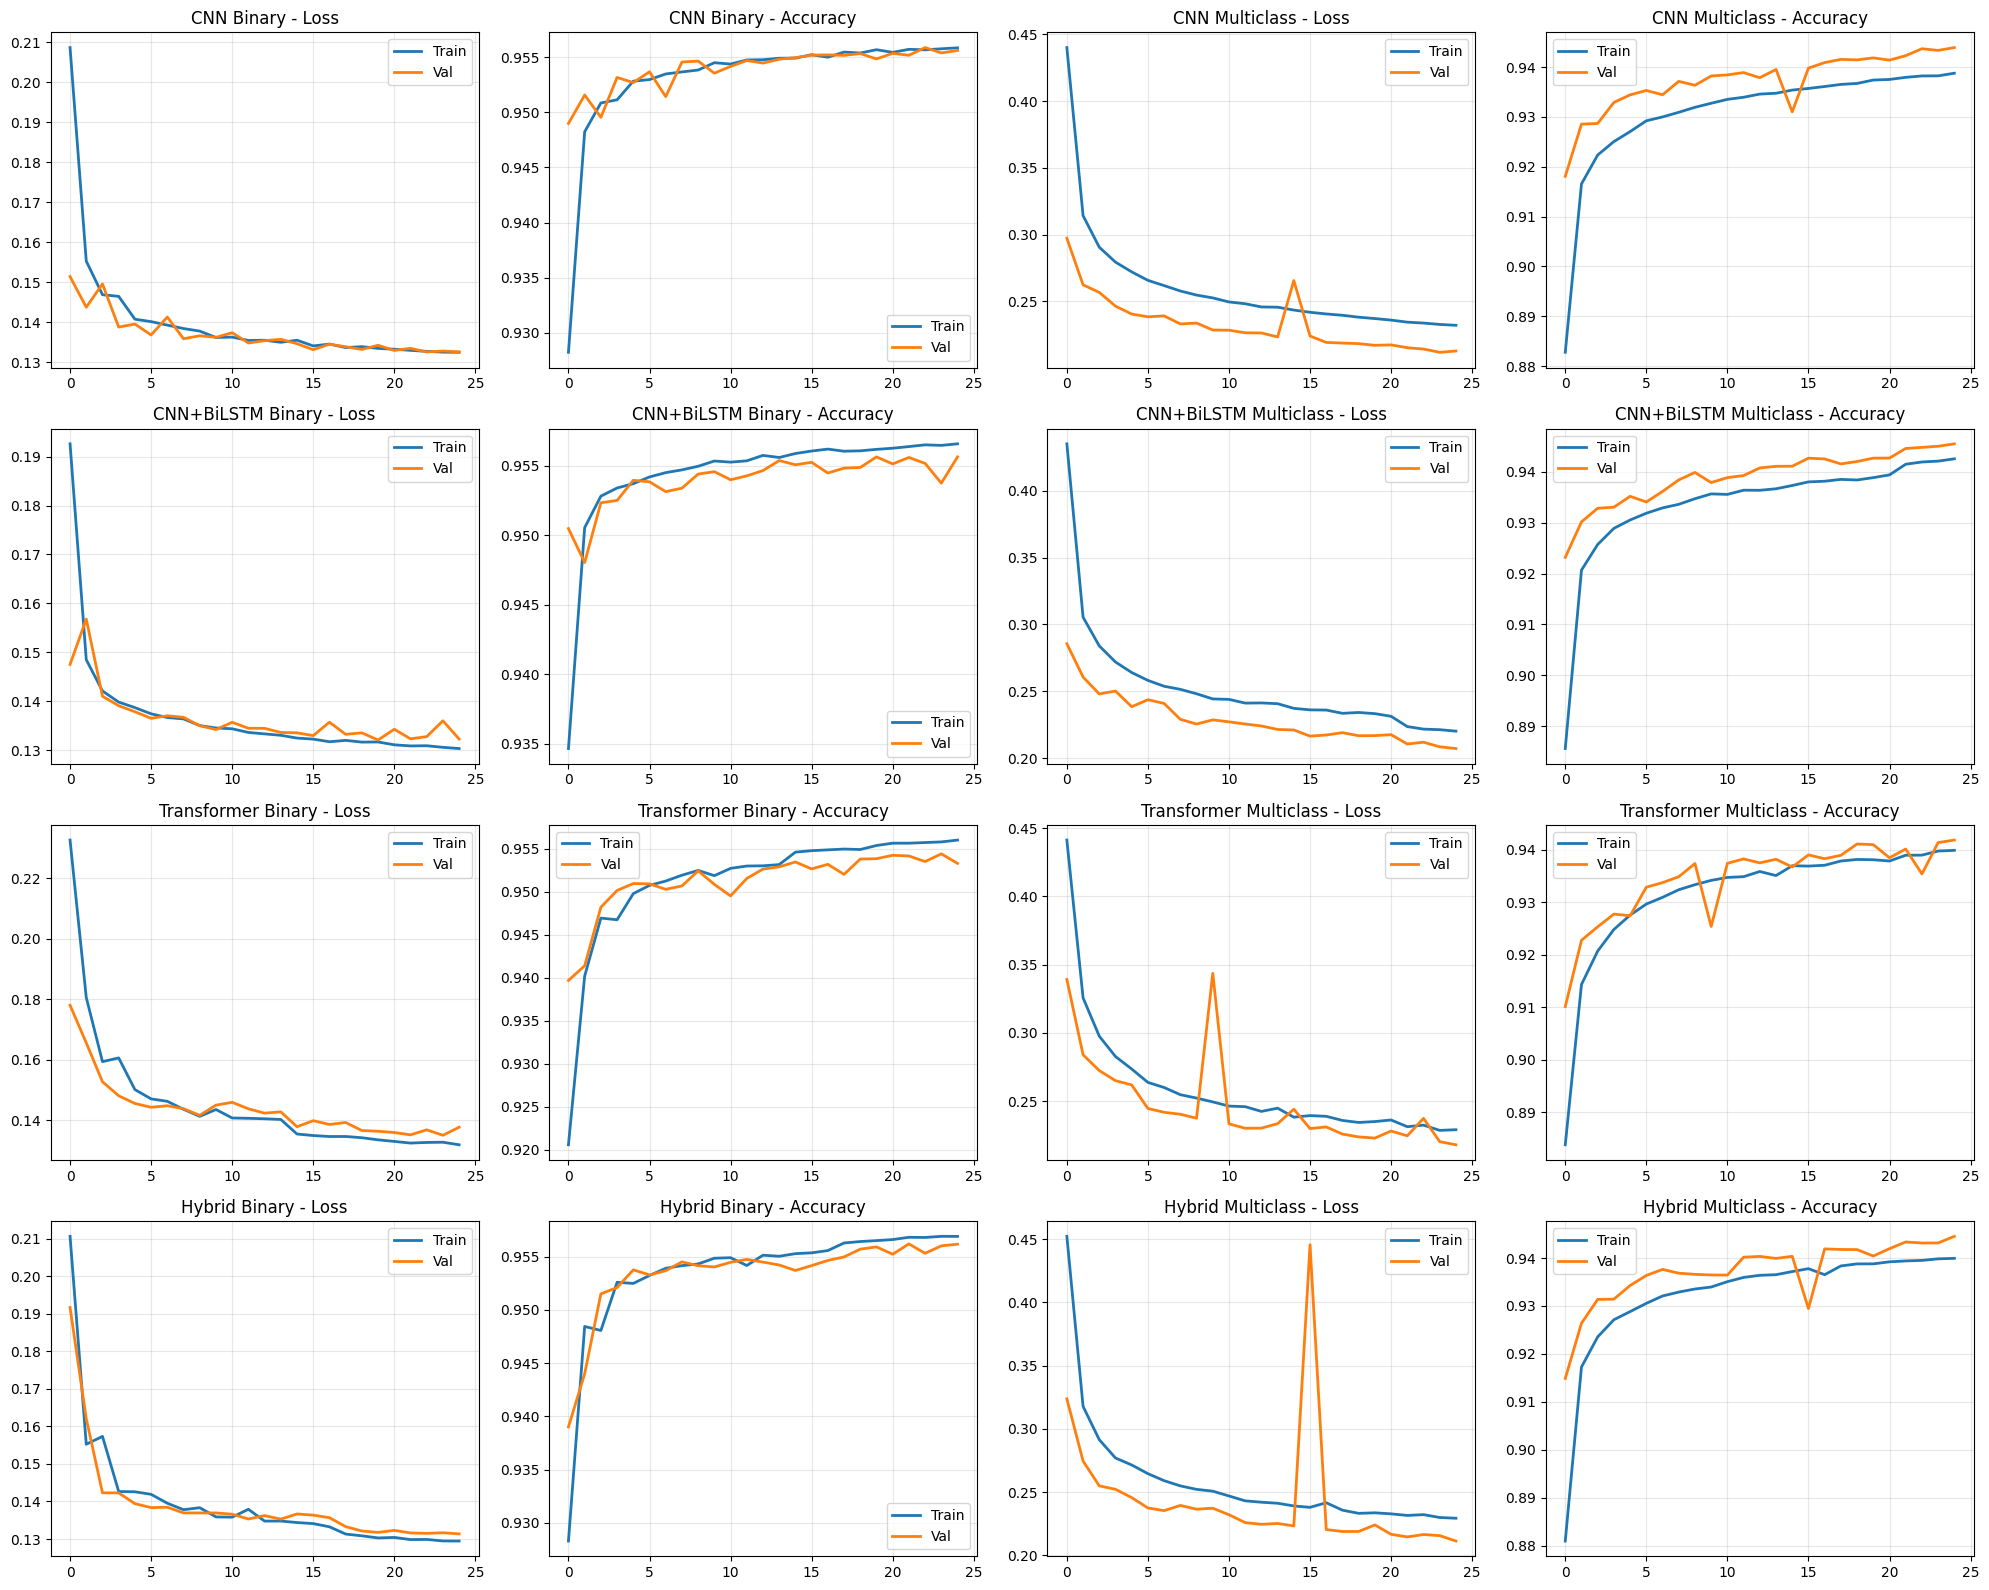

In [30]:
# ===============================
# VISUALISATION : COURBES D'ENTRAÎNEMENT TOUS MODÈLES
# ===============================
print("\n" + "=" * 80)
print("VISUALISATION : COURBES D'ENTRAÎNEMENT")
print("=" * 80)

fig, axes = plt.subplots(4, 4, figsize=(20, 16))

models_info = [
    ('CNN Binary', history_cnn_binary, 0),
    ('CNN Multiclass', history_cnn_multiclass, 1),
    ('CNN+BiLSTM Binary', history_cnn_bilstm_binary, 2),
    ('CNN+BiLSTM Multiclass', history_cnn_bilstm_multiclass, 3),
    ('Transformer Binary', history_transformer_binary, 0),
    ('Transformer Multiclass', history_transformer_multiclass, 1),
    ('Hybrid Binary', history_hybrid_binary, 2),
    ('Hybrid Multiclass', history_hybrid_multiclass, 3)
]

# Première ligne : CNN
axes[0, 0].plot(history_cnn_binary.history['loss'], label='Train', linewidth=2)
axes[0, 0].plot(history_cnn_binary.history['val_loss'], label='Val', linewidth=2)
axes[0, 0].set_title('CNN Binary - Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history_cnn_binary.history['accuracy'], label='Train', linewidth=2)
axes[0, 1].plot(history_cnn_binary.history['val_accuracy'], label='Val', linewidth=2)
axes[0, 1].set_title('CNN Binary - Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[0, 2].plot(history_cnn_multiclass.history['loss'], label='Train', linewidth=2)
axes[0, 2].plot(history_cnn_multiclass.history['val_loss'], label='Val', linewidth=2)
axes[0, 2].set_title('CNN Multiclass - Loss')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

axes[0, 3].plot(history_cnn_multiclass.history['accuracy'], label='Train', linewidth=2)
axes[0, 3].plot(history_cnn_multiclass.history['val_accuracy'], label='Val', linewidth=2)
axes[0, 3].set_title('CNN Multiclass - Accuracy')
axes[0, 3].legend()
axes[0, 3].grid(True, alpha=0.3)

# Deuxième ligne : CNN+BiLSTM
axes[1, 0].plot(history_cnn_bilstm_binary.history['loss'], label='Train', linewidth=2)
axes[1, 0].plot(history_cnn_bilstm_binary.history['val_loss'], label='Val', linewidth=2)
axes[1, 0].set_title('CNN+BiLSTM Binary - Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(history_cnn_bilstm_binary.history['accuracy'], label='Train', linewidth=2)
axes[1, 1].plot(history_cnn_bilstm_binary.history['val_accuracy'], label='Val', linewidth=2)
axes[1, 1].set_title('CNN+BiLSTM Binary - Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

axes[1, 2].plot(history_cnn_bilstm_multiclass.history['loss'], label='Train', linewidth=2)
axes[1, 2].plot(history_cnn_bilstm_multiclass.history['val_loss'], label='Val', linewidth=2)
axes[1, 2].set_title('CNN+BiLSTM Multiclass - Loss')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

axes[1, 3].plot(history_cnn_bilstm_multiclass.history['accuracy'], label='Train', linewidth=2)
axes[1, 3].plot(history_cnn_bilstm_multiclass.history['val_accuracy'], label='Val', linewidth=2)
axes[1, 3].set_title('CNN+BiLSTM Multiclass - Accuracy')
axes[1, 3].legend()
axes[1, 3].grid(True, alpha=0.3)

# Troisième ligne : Transformer
axes[2, 0].plot(history_transformer_binary.history['loss'], label='Train', linewidth=2)
axes[2, 0].plot(history_transformer_binary.history['val_loss'], label='Val', linewidth=2)
axes[2, 0].set_title('Transformer Binary - Loss')
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)

axes[2, 1].plot(history_transformer_binary.history['accuracy'], label='Train', linewidth=2)
axes[2, 1].plot(history_transformer_binary.history['val_accuracy'], label='Val', linewidth=2)
axes[2, 1].set_title('Transformer Binary - Accuracy')
axes[2, 1].legend()
axes[2, 1].grid(True, alpha=0.3)

axes[2, 2].plot(history_transformer_multiclass.history['loss'], label='Train', linewidth=2)
axes[2, 2].plot(history_transformer_multiclass.history['val_loss'], label='Val', linewidth=2)
axes[2, 2].set_title('Transformer Multiclass - Loss')
axes[2, 2].legend()
axes[2, 2].grid(True, alpha=0.3)

axes[2, 3].plot(history_transformer_multiclass.history['accuracy'], label='Train', linewidth=2)
axes[2, 3].plot(history_transformer_multiclass.history['val_accuracy'], label='Val', linewidth=2)
axes[2, 3].set_title('Transformer Multiclass - Accuracy')
axes[2, 3].legend()
axes[2, 3].grid(True, alpha=0.3)

# Quatrième ligne : Hybrid
axes[3, 0].plot(history_hybrid_binary.history['loss'], label='Train', linewidth=2)
axes[3, 0].plot(history_hybrid_binary.history['val_loss'], label='Val', linewidth=2)
axes[3, 0].set_title('Hybrid Binary - Loss')
axes[3, 0].legend()
axes[3, 0].grid(True, alpha=0.3)

axes[3, 1].plot(history_hybrid_binary.history['accuracy'], label='Train', linewidth=2)
axes[3, 1].plot(history_hybrid_binary.history['val_accuracy'], label='Val', linewidth=2)
axes[3, 1].set_title('Hybrid Binary - Accuracy')
axes[3, 1].legend()
axes[3, 1].grid(True, alpha=0.3)

axes[3, 2].plot(history_hybrid_multiclass.history['loss'], label='Train', linewidth=2)
axes[3, 2].plot(history_hybrid_multiclass.history['val_loss'], label='Val', linewidth=2)
axes[3, 2].set_title('Hybrid Multiclass - Loss')
axes[3, 2].legend()
axes[3, 2].grid(True, alpha=0.3)

axes[3, 3].plot(history_hybrid_multiclass.history['accuracy'], label='Train', linewidth=2)
axes[3, 3].plot(history_hybrid_multiclass.history['val_accuracy'], label='Val', linewidth=2)
axes[3, 3].set_title('Hybrid Multiclass - Accuracy')
axes[3, 3].legend()
axes[3, 3].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('all_models_training_curves.png', dpi=100, bbox_inches='tight')
plt.show()

### Interpretation of Training and Validation Curves

The image shows the **loss** and **accuracy** curves for four models (CNN, CNN+BiLSTM, Transformer, Hybrid) for **binary** and **multiclass** classification tasks. Each row corresponds to a model and each column corresponds to either loss or accuracy.

---

#### 1. **Binary Classification Loss**
- **Observation:**  
  For all models, the training loss decreases smoothly and converges around ~0.13–0.14, while validation loss closely follows, indicating good generalization.  
- **Interpretation:**  
  No significant overfitting is observed. The models are learning the patterns in the binary dataset effectively.

#### 2. **Binary Classification Accuracy**
- **Observation:**  
  Accuracy increases rapidly in the first few epochs, then plateaus around ~95–96% for all models. Validation accuracy closely tracks training accuracy.  
- **Interpretation:**  
  The models are stable and achieve high accuracy for binary classification. Hybrid and CNN+BiLSTM models slightly outperform others.

---

#### 3. **Multiclass Classification Loss**
- **Observation:**  
  Training loss steadily decreases for all models, but occasional spikes are seen in validation loss (especially for CNN+BiLSTM and Hybrid).  
- **Interpretation:**  
  The spikes could indicate that some validation batches contain harder examples or rare classes. Overall, models converge well with final loss ~0.21–0.22.

#### 4. **Multiclass Classification Accuracy**
- **Observation:**  
  Accuracy rises quickly and stabilizes around ~94–94.5% across models. Validation accuracy slightly fluctuates but follows the trend of training accuracy.  
- **Interpretation:**  
  All models perform well for multiclass tasks. Hybrid and CNN+BiLSTM achieve slightly better stability and higher accuracy on the validation set.

---

#### 5. **General Observations**
- **Binary vs Multiclass:** Binary classification achieves higher accuracy and lower loss, as expected due to simpler class distribution.  
- **Model Comparison:**  
  - **Hybrid Model:** Shows the best overall balance between training and validation, for both loss and accuracy, indicating strong generalization.  
  - **CNN+BiLSTM:** Performs slightly better than standalone CNN or Transformer, especially for multiclass tasks.  
  - **Transformer:** Competitive but slightly higher fluctuations in validation curves for multiclass.  
- **Training Behavior:** All models converge smoothly without significant overfitting, supported by the close alignment of training and validation curves.

---

**Conclusion:**  
The models are well-trained. For **binary tasks**, all models achieve excellent performance (~95–96% accuracy). For **multiclass tasks**, the Hybrid and CNN+BiLSTM models provide the best trade-off between stability and performance (~94–94.5% accuracy). Occasional validation spikes in multiclass loss are likely due to class imbalance.



MEILLEURES COURBES ROC (Binary & Multiclass)


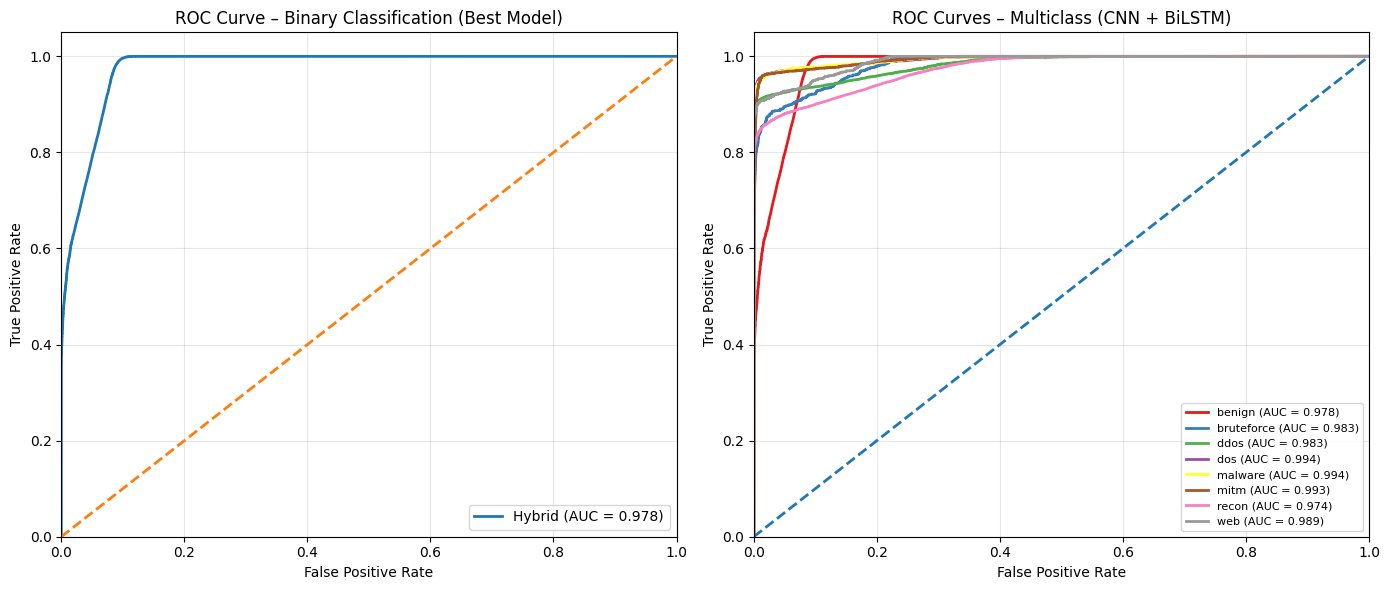

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

# ===============================
# VISUALISATION : MEILLEURES COURBES ROC
# ===============================
print("\n" + "=" * 80)
print("MEILLEURES COURBES ROC (Binary & Multiclass)")
print("=" * 80)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# =====================================================
# ROC BINARY – MEILLEUR MODÈLE : HYBRID
# =====================================================
fpr, tpr, _ = roc_curve(y_test_bin, y_pred_proba_hybrid_bin)
roc_auc = auc(fpr, tpr)

axes[0].plot(fpr, tpr, lw=2, label=f'Hybrid (AUC = {roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], lw=2, linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve – Binary Classification (Best Model)')
axes[0].legend(loc="lower right")
axes[0].grid(True, alpha=0.3)

# =====================================================
# ROC MULTICLASS – MEILLEUR MODÈLE : CNN + BiLSTM
# =====================================================
colors_multi = plt.cm.Set1(np.linspace(0, 1, num_classes))

for i, class_name in enumerate(label_encoder_multi.classes_):
    y_test_bin_multi = (y_test_mul == i).astype(int)
    y_pred_proba_class = y_pred_proba_cnn_bilstm_mul[:, i]

    fpr, tpr, _ = roc_curve(y_test_bin_multi, y_pred_proba_class)
    roc_auc_class = auc(fpr, tpr)

    axes[1].plot(
        fpr, tpr, lw=2, color=colors_multi[i],
        label=f'{class_name} (AUC = {roc_auc_class:.3f})'
    )

axes[1].plot([0, 1], [0, 1], lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves – Multiclass (CNN + BiLSTM)')
axes[1].legend(loc="lower right", fontsize=8)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('best_models_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()


### Interpretation of ROC Curves

These plots show the **ROC (Receiver Operating Characteristic) curves**, which measure the model's ability to distinguish between classes. The closer the curve is to the top-left corner (and the higher the AUC), the better the model's performance.

---

#### 1. Binary Classification (Hybrid Model)
- **Purpose:** Distinguish "normal" traffic from "attack" traffic.
- **AUC:** 0.978 → Excellent score. There is a 97.8% chance that the model correctly ranks a randomly chosen positive sample higher than a negative sample.
- **Curve Behavior:** The curve rises sharply vertically, indicating a high True Positive Rate (TPR) while maintaining a very low False Positive Rate (FPR).
- **Conclusion:** The hybrid model is highly reliable for overall anomaly detection.

---

#### 2. Multiclass Classification (CNN + BiLSTM)
- **Purpose:** Evaluate performance for each attack type.
- **Performance by Class (AUC):**
  - **Best-performing:** `dos` (0.994), `malware` (0.994), `mitm` (0.993) → near-perfect detection.
  - **Strong performance:** `bruteforce` (0.983), `ddos` (0.983), `web` (0.989).
  - **More challenging:** `recon` (0.974), `benign` (0.978) → slightly more prone to confusion.
- **Observation on "Benign":** The red curve (benign traffic) reaches the top slightly slower, suggesting occasional confusion between normal traffic and attacks.
- **Conclusion:** CNN+BiLSTM excels in granular classification, with nearly all classes above 0.98 AUC, demonstrating precise identification.

---

#### Comparison and Summary
- **Hybrid Model (Binary):** Excellent "sentinel" → detects anomalies reliably.
- **CNN+BiLSTM (Multiclass):** Excellent "analyst" → identifies the exact type of attack with very high reliability (>97% AUC for almost all classes).
- **Implication:** Using CNN+BiLSTM in cybersecurity is highly effective, as it not only detects an attack but also accurately classifies its type.



MEILLEUR MODÈLE BINAIRE : HYBRIDE (CNN-based)

Rapport de classification (Binary):
              precision    recall  f1-score   support

      attack       0.99      0.90      0.94     42750
      benign       0.94      0.99      0.96     60101

    accuracy                           0.96    102851
   macro avg       0.96      0.95      0.95    102851
weighted avg       0.96      0.96      0.96    102851


MEILLEUR MODÈLE MULTICLASS : CNN + BiLSTM

Rapport de classification (Multiclass):
              precision    recall  f1-score   support

      benign       0.93      1.00      0.96     60101
  bruteforce       0.94      0.64      0.76       902
        ddos       0.98      0.88      0.93      8504
         dos       0.97      0.93      0.95      8660
     malware       0.97      0.90      0.94      3627
        mitm       0.87      0.92      0.89      3824
       recon       0.98      0.82      0.89     15877
         web       0.99      0.87      0.93      1356

    accuracy     

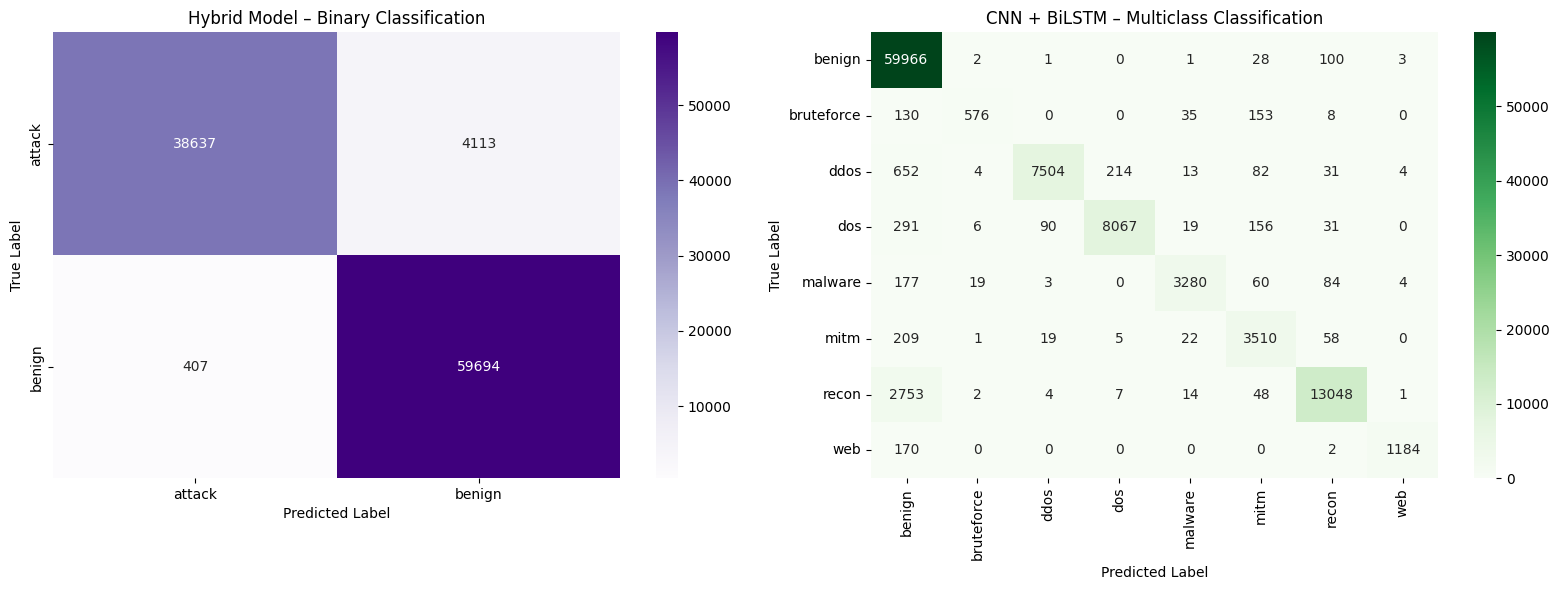

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# =====================================================
# MEILLEUR MODÈLE BINAIRE : HYBRIDE (4A)
# =====================================================
print("\n" + "=" * 80)
print("MEILLEUR MODÈLE BINAIRE : HYBRIDE (CNN-based)")
print("=" * 80)

# Prédictions
y_pred_proba_hybrid_bin = model_hybrid_binary.predict(X_test_bin, verbose=0)
y_pred_hybrid_bin = (y_pred_proba_hybrid_bin > 0.5).astype(int).flatten()

# Rapport
print("\nRapport de classification (Binary):")
print(classification_report(
    y_test_bin,
    y_pred_hybrid_bin,
    target_names=label_encoder_binary.classes_
))

# Matrice de confusion
cm_hybrid_bin = confusion_matrix(y_test_bin, y_pred_hybrid_bin)

# =====================================================
# MEILLEUR MODÈLE MULTICLASS : CNN + BiLSTM (2B)
# =====================================================
print("\n" + "=" * 80)
print("MEILLEUR MODÈLE MULTICLASS : CNN + BiLSTM")
print("=" * 80)

# Prédictions
y_pred_proba_cnn_bilstm_mul = model_cnn_bilstm_multiclass.predict(X_test_mul, verbose=0)
y_pred_cnn_bilstm_mul = np.argmax(y_pred_proba_cnn_bilstm_mul, axis=1)

# Rapport
print("\nRapport de classification (Multiclass):")
print(classification_report(
    y_test_mul,
    y_pred_cnn_bilstm_mul,
    target_names=label_encoder_multi.classes_
))

# Matrice de confusion
cm_cnn_bilstm_mul = confusion_matrix(y_test_mul, y_pred_cnn_bilstm_mul)

# =====================================================
# VISUALISATION : MATRICES DE CONFUSION (BEST MODELS)
# =====================================================
print("\n" + "=" * 80)
print("VISUALISATION : MATRICES DE CONFUSION (BEST MODELS)")
print("=" * 80)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Binaire : Hybride ---
sns.heatmap(
    cm_hybrid_bin,
    annot=True,
    fmt='d',
    cmap='Purples',
    ax=axes[0],
    xticklabels=label_encoder_binary.classes_,
    yticklabels=label_encoder_binary.classes_
)
axes[0].set_title("Hybrid Model – Binary Classification")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# --- Multiclasse : CNN + BiLSTM ---
sns.heatmap(
    cm_cnn_bilstm_mul,
    annot=True,
    fmt='d',
    cmap='Greens',
    ax=axes[1],
    xticklabels=label_encoder_multi.classes_,
    yticklabels=label_encoder_multi.classes_
)
axes[1].set_title("CNN + BiLSTM – Multiclass Classification")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.tight_layout()
plt.savefig("best_models_confusion_matrices.png", dpi=300, bbox_inches="tight")
plt.show()


# 🏆 Evaluation of the Best Models

---

## 🔹 Best Binary Model: Hybrid (CNN+bilstm+transformer-based)

**Classification Report:**

| Class   | Precision | Recall | F1-score | Support |
|---------|-----------|--------|----------|---------|
| attack  | 0.99      | 0.90   | 0.94     | 42,750  |
| benign  | 0.94      | 0.99   | 0.96     | 60,101  |
| **Accuracy** | - | - | **0.96** | 102,851 |
| **Macro Avg** | 0.96 | 0.95 | 0.95 | 102,851 |
| **Weighted Avg** | 0.96 | 0.96 | 0.96 | 102,851 |

**Interpretation:**

- Overall accuracy is very high: **96%**.
- Attacks are detected with **99% precision**, but recall is 90% → **10% of attacks are missed**.
- The benign class is detected with a good balance of precision and recall (94%-99%).
- The model is reliable for attack detection while minimizing false positives on the benign class.

---

## 🔹 Best Multiclass Model: CNN + BiLSTM

**Classification Report:**

| Class      | Precision | Recall | F1-score | Support |
|------------|-----------|--------|----------|---------|
| benign     | 0.93      | 1.00   | 0.96     | 60,101 |
| bruteforce | 0.94      | 0.64   | 0.76     | 902    |
| ddos       | 0.98      | 0.88   | 0.93     | 8,504  |
| dos        | 0.97      | 0.93   | 0.95     | 8,660  |
| malware    | 0.97      | 0.90   | 0.94     | 3,627  |
| mitm       | 0.87      | 0.92   | 0.89     | 3,824  |
| recon      | 0.98      | 0.82   | 0.89     | 15,877 |
| web        | 0.99      | 0.87   | 0.93     | 1,356  |
| **Accuracy** | - | - | **0.94** | 102,851 |
| **Macro Avg** | 0.95 | 0.87 | 0.91 | 102,851 |
| **Weighted Avg** | 0.95 | 0.94 | 0.94 | 102,851 |

**Interpretation:**

- Overall accuracy: **94%**, very satisfactory for a multiclass problem.
- The majority class **benign** is perfectly recognized (recall = 1.0).
- Some rare classes such as **bruteforce** have low recall (64%) → **the model struggles to detect certain infrequent attacks**.
- High F1-scores for most classes → good balance between precision and recall.
- The model is robust for distinguishing multiple attack types with few false positives.

---

## 🔹 Visualization: Confusion Matrices

- **Binary**: false negatives are mainly attacks.
- **Multiclass**: main confusions occur on rare classes (**bruteforce, recon, web**).
- Using **heatmaps** is recommended to clearly visualize class-wise errors.

---

> ✅ **Conclusion:**
> 
> - For **binary classification**, the hybrid CNN+Bilstm+Transformer model is highly effective and reliable for detecting attacks.  
> - For **multiclass classification**, the CNN + BiLSTM model offers a good balance between precision and recall while effectively distinguishing most types of attacks.
